<a href="https://colab.research.google.com/github/JorgeMiguelGomes/fma-analysis-vostpt/blob/main/VOSTPT_FMA_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANALYSIS OF ADVERSE WEATHER PHENOMENA (ANÁLISE DE FENÓMENOS METEOROLÓGICOS ADVERSOS)

## DATA VIA FOGOS.PT API

### Objectives

**This notebook allows for the analysis of data coming from the FOGOS.PT API and create reports and visualizations for a determined time period, normally associated with an adverse weather phenomena. The origin of the data provided by the API comes directly from [ANEPC](https://prociv.pt)**


---

### Objectivos

**Este *notebook* permite analisar os dados provenientes da API do FOGOS.PT e criar relatórios e visualizações de um determinado período temporal, normalmente associado a um fenómeno meteorológico adverso. A origem dos dados fornecidos pela API vem diretamente da [ANEPC](https://prociv.pt)**



---



### Credits

**Developed by [Jorge Gomes](https://twitter.com/jgomes_eu) for VOST Portugal with 🤍**

**API developed by [João Pina](https://twitter.com/tomahock)**

### License (Licença)


<a href="https://colab.research.google.com/drive/1nDTNPdHLoKZm18ySQAvWKAQY9fGkjj0_?usp=sharing">VOST FMA Analysis</a> by <a href="https://twitter.com/jgomes_eu">Jorge Gomes</a> for <a href="https://vost.pt">VOST Portugal</a> is licensed under<br>
<a href="http://creativecommons.org/licenses/by-nc-sa/4.0/?ref=chooser-v1" target="_blank">Attribution-NonCommercial-ShareAlike 4.0 International<br>

# Libraries (Bibliotecas)

**Install the libraries that are not installed by default in Google Colab**

**Instala as bibliotecas que não são instaladas por defeito no Google Colab**

---

**Import all libraries to the environment**
**Importa todas as bibliotecas para o ambiente de desenvolvimento**

In [ ]:
!pip install h3pandas
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.2/115.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.5 MB/s eta 0:00:00
  Created wheel for h3pandas: filename=h3pandas-0.2.4-py3-none-any.whl size=17657 sha256=15ed0cd204f3b19316f49fc684150a0c22b576b1714535c113bcde62362afc0a
  Stored in directory: /root/.cache/pip/wheels/b7/c1/a1/cfc5bbcd909a037e628ab0bb3717f72f9a2e599f0cfb322520
Successfully built h3pandas
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.3 MB/s eta 0:00:00


#### Import required libraries

In [ ]:
import pandas as pd
import geopandas as gpd
import json
import h3pandas
import unidecode
import matplotlib.pyplot as plt
import requests
import datetime as dt
from datetime import datetime, timedelta, date
import seaborn as sns
import folium
from folium.plugins import HeatMap
import matplotlib
import matplotlib.dates as mdates
from matplotlib.font_manager import FontProperties
from google.colab import files
import zipfile
import tempfile
import shutil
import os
import numpy as np

#Data Files for Analysis (Dados para Análise )
**API FOGOS.PT**

https://api.fogos.pt/v2/incidents/search?all=1&after= **2023-10-16** &limit=30000

**Please change the date to the day before the day you want to analyse**

**Por favor, altera a data para o dia anterior ao dia que deseja analisar**

In [ ]:
# Define the call to the API
url_bar="https://api.fogos.pt/v2/incidents/search?all=1&after=2023-10-16&limit=30000"
# Get response from the API
response = requests.get(url_bar)
# Get the json content from the response
json = response.json()
# Create a pandas dataframe
raw_data = pd.json_normalize(json,'data')
# This is necessary to set the date of the dataset to local time
raw_data['date_time']=pd.to_datetime(raw_data['date'] + ' '+raw_data['hour'],format='%d-%m-%Y %H:%M')

In [ ]:
# Define the naturezaCode for FMA (Official from ANEPC)
# Convert the codes to strings since the unique values in 'naturezaCode' are strings
codes = ['1101', '1103', '1107', '1109', '1111', '1115', '1125',
         '3301', '3303', '3305', '3307', '3309', '3311', '3313',
         '3315', '3321', '3323', '3325', '3329', '3333',
         '2501', '2503', '2507', '2509']

# Filter the data

# Filter the data
data = raw_data[raw_data['naturezaCode'].isin(codes)].copy()
data['date_time']=pd.to_datetime(data['date'] + ' '+data['hour'],format='%d-%m-%Y %H:%M')

## Optional Filtering
**Use this just in case you want to have a report for the last x hours**

In [ ]:
# Get the current time
current_time = datetime.now()

# Calculate the time for x hours ago
hours_ago = current_time - timedelta(hours=4)

# Filter the dataframe
data = data[data['date_time'] > hours_ago]

## DATA TREATMENT / TRATAMENTO DE DADOS

In [ ]:
# Define the Period that is being analysed
start_date = data['date_time'].min()
end_date = data['date_time'].max()

# Convert the timestamps to strings in the desired format
start_date_str = start_date.strftime('%Y-%m-%d %H:%M')
end_date_str = end_date.strftime('%Y-%m-%d %H:%M')

print(start_date_str,end_date_str)

2023-10-16 07:21 2023-10-20 17:29


# Dataset Summary (Resumo dos Dados)

**This code analyzes incident data, calculating the total number of occurrences, the top three incident types, and the top three counties where the biggest number of occurrences happened. It also examines incident frequency by hour and computes the average number of operational personnel involved. The code identifies the incident with the highest personnel involvement and extracts relevant details. Results are collected in a dictionary, translated to Portuguese, and formatted. The code calculates a time interval for peak incident frequency and generates a detailed Portuguese summary, offering insights into occurrence frequency, nature, timing, and response.**

**The second block of code generates a series of tweets with the same insights to be published**

---

**Este código analisa dados de ocorrências, calculando o número total de ocorrências, os três principais tipos de incidentes e os três principais concelhos onde existiram o maior número de ocorrências. Também examina a frequência de ocorrências por hora e calcula o número médio de pessoal operacional envolvido. O código identifica o incidente com maior envolvimento do pessoal e extrai detalhes relevantes. Os resultados são coletados em um dicionário, traduzidos para português e formatados. O código calcula um intervalo de tempo para a frequência de pico de incidentes e gera um resumo detalhado em português, oferecendo insights sobre a frequência, natureza, tempo e resposta da ocorrência**

**O segundo bloco de código gera uma série de tweets com os mesmos insights para serem publicados**

##### Sumary (Resumo)

In [ ]:
# Duplicate Dataframe for data integrity purposes
incident_data_full = data

# Count of Incidents
total_incidents = len(incident_data_full)

# Incidents by Type (Natureza)
incidents_by_natureza = incident_data_full['natureza'].value_counts().head(3)

# Incidents by Location (Concelho)
incidents_by_concelho = incident_data_full['concelho'].value_counts().head(3)

# Convert to DataFrame
incidents_by_concelho_df = incidents_by_concelho.reset_index()
incidents_by_concelho_df.columns = ['concelho', 'number_of_incidents']

# Incident Frequency Over Time (per hour)
# Extract the hour from the datetime
incident_data_full['hour'] = incident_data_full['date_time'].dt.hour

# Count the number of incidents for each hour
incidents_by_hour = incident_data_full['hour'].value_counts().sort_index()

# Response Statistics
# Calculating the average number of personnel (man) involved in incidents
average_personnel = incident_data_full['man'].mean()

# Find the incident with the most personnel involved
max_personnel_incident = incident_data_full.loc[incident_data_full['man'].idxmax()]

# Extract relevant information from the incident
max_personnel_natureza = max_personnel_incident['natureza']
max_personnel_concelho = max_personnel_incident['concelho']
max_personnel_district = max_personnel_incident['district']
max_personnel_count = max_personnel_incident['man']

# Define start_date_str and end_date_str with the desired format
start_date_str = "2023-10-16 07:21"
end_date_str = "2023-10-20 11:28"

# Collecting the results
statistics = {
    "total_incidents": total_incidents,
    "incidents_by_natureza": incidents_by_natureza,
    "incidents_by_concelho": incidents_by_concelho,
    "incidents_by_hour": incidents_by_hour,
    "average_personnel_per_incident": average_personnel,
    "start_date": start_date_str,
    "end_date": end_date_str
}

# dictionary key and variable references
translation_dict = {
    "total_incidents": "Total de Ocorrências",
    "incidents_by_natureza": "Tipos de Ocorrências",
    "incidents_by_concelho": "Ocorrências por Concelho",
    "incidents_by_hour": "Frequência de Ocorrências ao Longo do Tempo (por hora)",
    "average_personnel_per_incident": "Média de Operacionais por Ocorrência",
    "max_personnel_incident": "Ocorrência com Mais Operacionais Envolvidos",
    "start_date": "Data de Início",
    "end_date": "Data de Fim"
}

# Convert statistics dictionary keys and certain values to Portuguese
statistics_pt = {
    translation_dict[key]: value if key not in ['incidents_by_natureza', 'incidents_by_concelho'] else {
        sub_key: sub_value for sub_key, sub_value in value.items()
    } for key, value in statistics.items()
}

# Calculate the time interval for the "Frequência de Ocorrências ao Longo do Tempo (por hora)" section
max_hour = statistics['incidents_by_hour'].idxmax()
time_interval_start = f"{max_hour:02}:00"
time_interval_end = f"{(max_hour + 1) % 24:02}:00"

# Generate a summary text in Portuguese, and make sure to use the correct keys
summary_text = f"""
Período analisado: De {statistics['start_date']} a {statistics['end_date']}

1. {translation_dict['total_incidents']}: {statistics['total_incidents']} ocorrências
2. {translation_dict['incidents_by_natureza']}: Os tipos de ocorrências mais comuns foram: {', '.join([f'{natureza} ({count} ocorrências)' for natureza, count in statistics['incidents_by_natureza'].items()])}.
3. {translation_dict['incidents_by_concelho']}: Os concelhos com mais ocorrências foram: {', '.join([f'{concelho} ({count} ocorrências)' for concelho, count in statistics['incidents_by_concelho'].items()])}.
4. {translation_dict['incidents_by_hour']}: O intervalo horário com mais ocorrências foi entre as {time_interval_start}h e as {time_interval_end}h ({statistics['incidents_by_hour'].max()} ocorrências).
5. {translation_dict['average_personnel_per_incident']}: Em média, cerca de {statistics['average_personnel_per_incident']:.0f} operacionais estiveram envolvidos por ocorrência.
6. {translation_dict['max_personnel_incident']}: A ocorrência com mais operacionais envolveu {max_personnel_count} operacionais. Ocorrência de natureza {max_personnel_natureza} no concelho de {max_personnel_concelho}, distrito de {max_personnel_district}.


"""

# Print summary text
print(summary_text)



Período analisado: De 2023-10-16 07:21 a 2023-10-20 11:28

1. Total de Ocorrências: 3766 ocorrências
2. Tipos de Ocorrências: Os tipos de ocorrências mais comuns foram: Queda de Árvore (1664 ocorrências), Inundação de estruturas ou superfícies por precipitação intensa (1478 ocorrências), Queda de elementos de construção em estruturas edificadas (177 ocorrências).
3. Ocorrências por Concelho: Os concelhos com mais ocorrências foram: Porto (211 ocorrências), Vila Nova De Gaia (120 ocorrências), Sintra (118 ocorrências).
4. Frequência de Ocorrências ao Longo do Tempo (por hora): O intervalo horário com mais ocorrências foi entre as 14:00h e as 15:00h (307 ocorrências).
5. Média de Operacionais por Ocorrência: Em média, cerca de 3 operacionais estiveram envolvidos por ocorrência.
6. Ocorrência com Mais Operacionais Envolvidos: A ocorrência com mais operacionais envolveu 33 operacionais. Ocorrência de natureza Queda de Árvore no concelho de Aljezur, distrito de Faro.

Estas estatísticas fo

##### Tweet Summary (Resumo para o Twitter)

In [ ]:
# Create a series of tweets in VOST Portugal's style
tweets = []

# Tweet 1: Introduction
tweet = "🚨📊 Resumo de Ocorrências 📊🚨\n\n"
tweet += f"📅 Período analisado: {start_date_str} a {end_date_str}\n"
tweet += f"ℹ️ Total de Ocorrências: {statistics['total_incidents']} ocorrências\n"
tweet += "👇 Mais detalhes abaixo 👇"
tweets.append(tweet)

# Tweet 2: Types of Incidents
tweet = "🔍 Tipos de Ocorrências Mais Comuns:\n"
for natureza, count in statistics['incidents_by_natureza'].items():
    tweet += f"• {natureza}: {count} ocorrências\n"
tweets.append(tweet)

# Tweet 3: Incidents by Location
tweet = "📍 Ocorrências por Concelho:\n"
for concelho, count in statistics['incidents_by_concelho'].items():
    tweet += f"• {concelho}: {count} ocorrências\n"
tweets.append(tweet)

# Tweet 4: Incidents by Hour
tweet = f"🕒 Maior Frequência às {time_interval_start}-{time_interval_end}:\n"
tweet += f"• {statistics['incidents_by_hour'].max()} ocorrências\n"
tweets.append(tweet)

# Tweet 5: Average Personnel per Incident
tweet = f"👥 Média de Operacionais por Ocorrência: {statistics['average_personnel_per_incident']:.0f}\n"
tweets.append(tweet)

# Tweet 6: Incident with Most Personnel
tweet = f"🚒 Maior Mobilização de Recursos:\n"
tweet += f"• Ocorrência de {max_personnel_natureza}\n"
tweet += f"• Concelho: {max_personnel_concelho}, Distrito: {max_personnel_district}\n"
tweet += f"• {max_personnel_count} operacionais envolvidos\n"
tweets.append(tweet)

# Print the individual tweets
for i, tweet in enumerate(tweets):
    print(f"Tweet {i + 1}:")
    print(tweet)
    print("\n")

Tweet 1:
🚨📊 Resumo de Ocorrências 📊🚨

📅 Período: 2023-10-16 07:21 a 2023-10-20 11:28
ℹ️ Total de Ocorrências: 3766 ocorrências
👇 Mais detalhes abaixo 👇


Tweet 2:
🔍 Tipos de Ocorrências Mais Comuns:
• Queda de Árvore: 1664 ocorrências
• Inundação de estruturas ou superfícies por precipitação intensa: 1478 ocorrências
• Queda de elementos de construção em estruturas edificadas: 177 ocorrências



Tweet 3:
📍 Ocorrências por Concelho:
• Porto: 211 ocorrências
• Vila Nova De Gaia: 120 ocorrências
• Sintra: 118 ocorrências



Tweet 4:
🕒 Maior Frequência às 14:00-15:00:
• 307 ocorrências



Tweet 5:
👥 Média de Operacionais por Ocorrência: 3



Tweet 6:
🚒 Maior Mobilização de Recursos:
• Ocorrência de Queda de Árvore
• Concelho: Aljezur, Distrito: Faro
• 33 operacionais envolvidos



Tweet 7:
📈 Estas estatísticas fornecem insights valiosos sobre as ocorrências e resposta em Portugal. #Ocorrências #Estatísticas

Acompanhe-nos para atualizações em tempo real.




## Data Visualisation Products (Produtos de Visualização de Dados)

**The following code blocks produces, and saves in the local computer, a set of visualizations that can help you tell the story of the event**

---

**Os blocos de código a seguir produzem e salvam no computador local um conjunto de visualizações que podem ajudar você a contar a história do evento**


#### Occurences by District (Ocorrências por Distrito)

This code analyzes occurrence data to identify the top 10 types of occurrences (natureza) in different districts. It calculates the frequency of each natureza per district and uses this data to create a heatmap visualization. The heatmap displays these frequencies using color gradations, providing a clear visual representation of the most common occurrence types across districts within a specified date range. Labels, titles, and annotations are added for context, and the final high-resolution image is saved for sharing or further use.


---


Este código analisa dados de ocorrências para identificar os 10 principais tipos de ocorrências (natureza) em diferentes distritos. Calcula a frequência de cada natureza por distrito e usa esses dados para criar uma visualização em mapa de calor. O mapa de calor exibe essas frequências usando graduações de cor, fornecendo uma representação visual clara dos tipos de ocorrências mais comuns entre os distritos dentro de um intervalo de datas especificado. Rótulos, títulos e anotações são adicionados para contexto, e a imagem final em alta resolução é gravada para partilha ou uso posterior.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

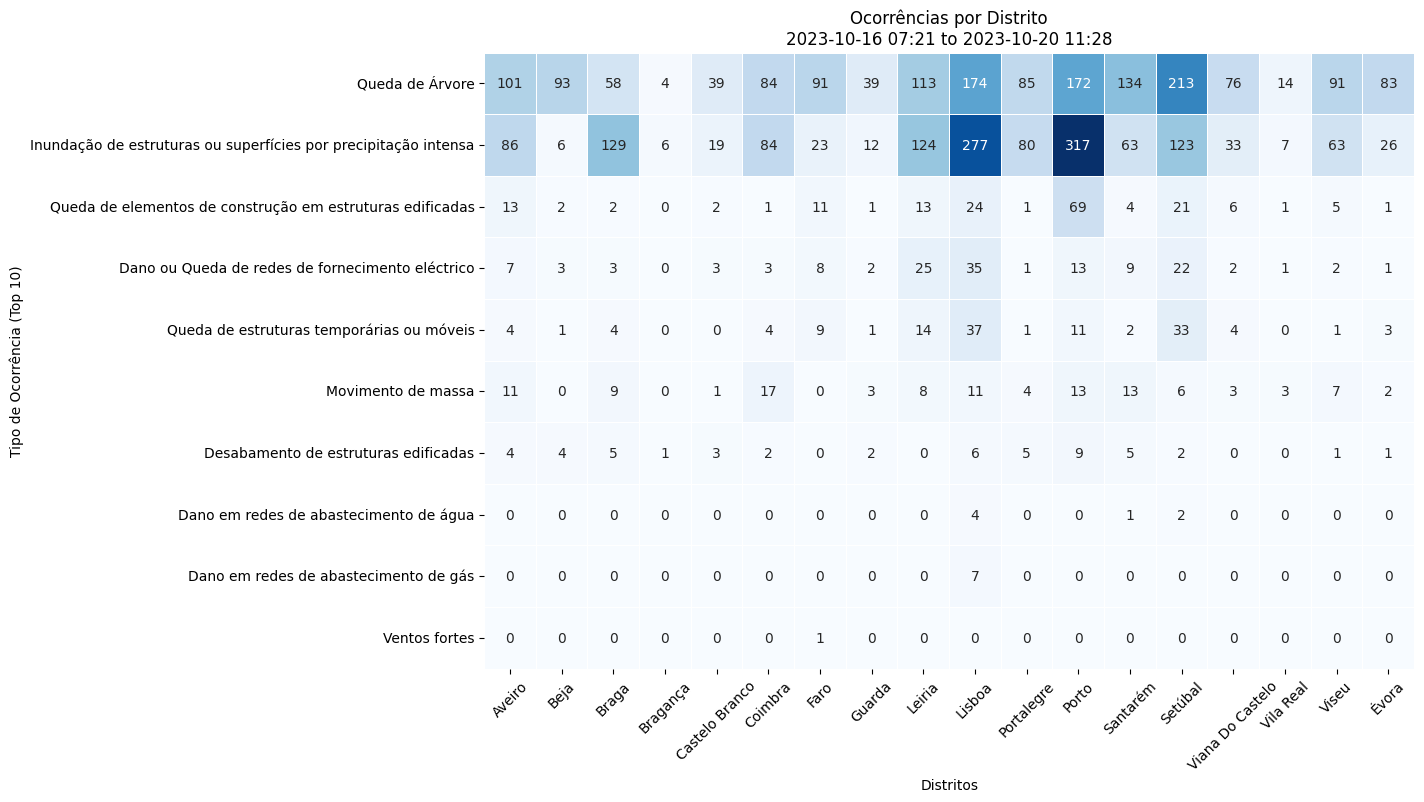

In [ ]:
# Calculate the frequency of each 'natureza' for each district
natureza_district_crosstab = pd.crosstab(incident_data_full['natureza'], incident_data_full['district'])

# Get the top 10 'natureza' types
top_naturezas = incident_data_full['natureza'].value_counts().nlargest(10).index

# Filter the crosstab for only the top 10 'natureza' types
top_natureza_district_crosstab = natureza_district_crosstab.loc[top_naturezas]


# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(top_natureza_district_crosstab, annot=True, fmt="d", cmap='Blues', linewidths=.5,cbar=False)

# Set the labels
plt.xlabel('Distritos')
plt.ylabel('Tipo de Ocorrência (Top 10)')
plt.title(f'Ocorrências por Distrito\n{start_date_str} to {end_date_str}', loc='center')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
# Save the plot for dissemination
filename=f'distrito_high_res_{end_date_str}.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')
files.download(filename)
plt.show()

#### Occurrences by Municipality for the District with the most Occurrences (Ocorrências por Concelho para o Distrito com mais Ocorrências)

This code analyzes occurrence data to determine the district with the highest number of occurrences. It first identifies the district with the most occurrences (top_district) and then filters the dataset for that specific district. Within this district, the code calculates the frequency of each occurrence type (natureza) for each county (concelho). After identifying the top 10 occurrence types in the district, it creates a heatmap to visually display the frequency of these top occurrences across the counties. The heatmap uses color intensity to represent frequency differences, and numerical annotations provide specific counts. Custom labels and titles are used, highlighting the district in focus and the analysis period. The final visualization is saved as a high-resolution image for download or future reference.


---


Este código analisa dados de ocorrências para determinar o distrito com o maior número de ocorrências. Primeiro, identifica o distrito com mais ocorrências (top_district) e, em seguida, filtra o conjunto de dados para esse distrito específico. Dentro deste distrito, o código calcula a frequência de cada tipo de ocorrência (natureza) para cada concelho (concelho). Após identificar os 10 principais tipos de ocorrências no distrito, ele cria um mapa de calor para exibir visualmente a frequência dessas principais ocorrências nos concelhos. O mapa de calor usa a intensidade da cor para representar diferenças de frequência, e anotações numéricas fornecem contagens específicas. Rótulos e títulos personalizados são usados, destacando o distrito em foco e o período de análise. A visualização final é salva como uma imagem de alta resolução para download ou referência futura.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

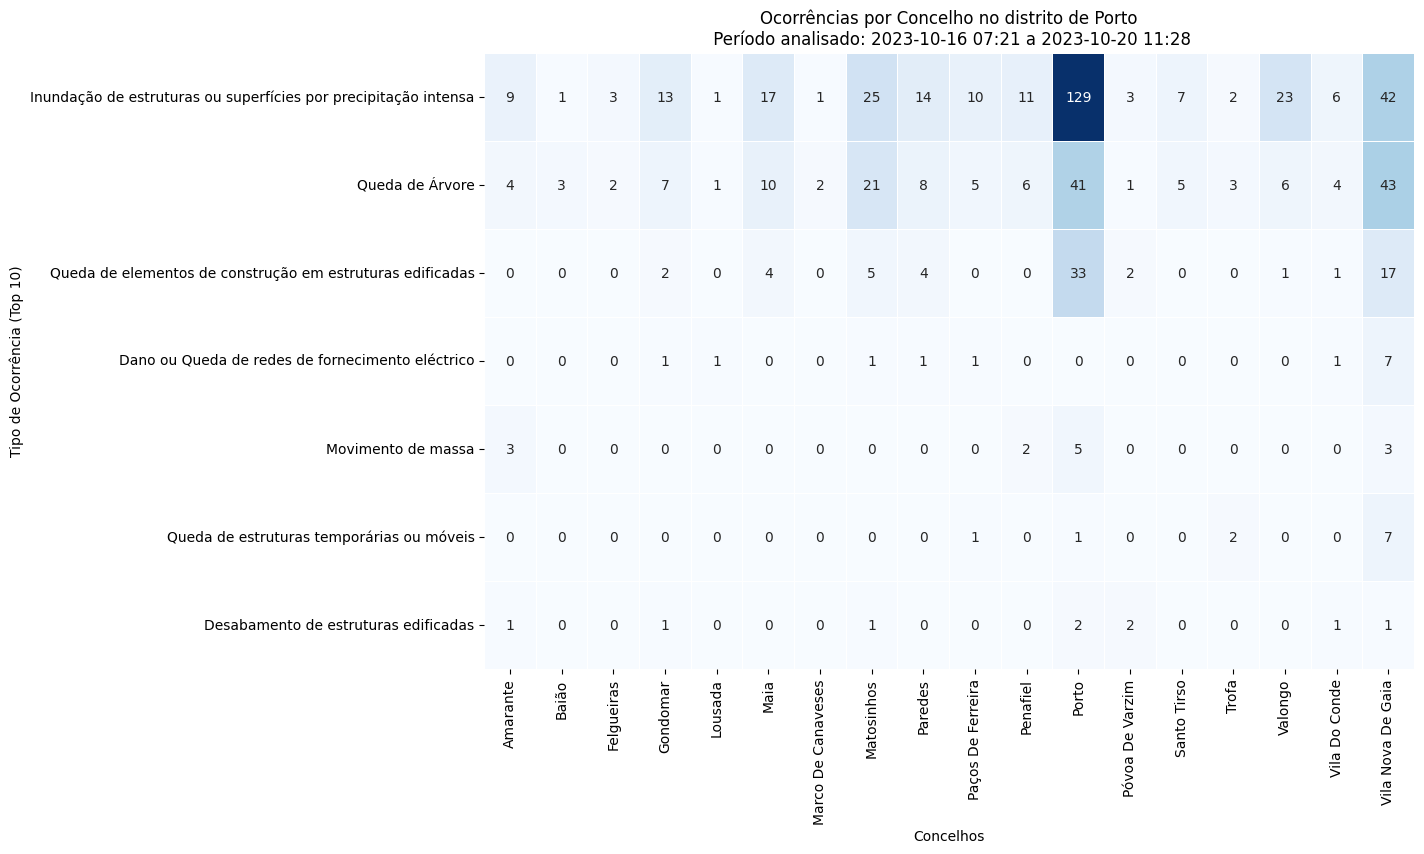

In [ ]:
# Identify the district with the most incidents
top_district = incident_data_full['district'].value_counts().idxmax()

# Filter the data for that district
district_data = incident_data_full[incident_data_full['district'] == top_district]

# Calculate the frequency of each 'natureza' for each 'concelho' in the top district
natureza_concelho_crosstab = pd.crosstab(district_data['natureza'], district_data['concelho'])

# Get the top 10 'natureza' types
top_naturezas = district_data['natureza'].value_counts().nlargest(10).index

# Filter the crosstab for only the top 10 'natureza' types
top_natureza_concelho_crosstab = natureza_concelho_crosstab.loc[top_naturezas]

# Create the heatmap
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(top_natureza_concelho_crosstab, annot=True, fmt="d", cmap='Blues', linewidths=.5, cbar=False)

# Set the labels and titles with the top district
plt.xlabel('Concelhos')
plt.ylabel('Tipo de Ocorrência (Top 10)')
plt.title(f'Ocorrências por Concelho no distrito de {top_district}\n Período analisado: {start_date_str} a {end_date_str}', loc='center')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Save the figure in high resolution
filename=f'concelho_high_res_{end_date_str}.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')
files.download(filename)
plt.show()


#### Counties Top 10 in Occurences (Concelhos Top 10 in Occurences)

**This code identifies the top 10 affected counties ("concelho") in the dataset of incidents. It counts the occurrences for each county, creates a DataFrame to store these top 10 counties along with their incident counts, and then generates a DataFrame for these top counties exclusively.**

**Subsequently, it creates a heatmap using Seaborn, visually displaying the frequencies of various incident types ("natureza") across the top 10 counties. Labels and titles are added for clarity, and the resulting heatmap is saved as a high-resolution image, named after the end date of the analyzed period, for sharing or further use.**

---

**Este código identifica os 10 concelhos mais afetados (“concelho”) no conjunto de dados de incidentes. Ele conta as ocorrências para cada concelho, cria um DataFrame para armazenar esses 10 principais concelhos junto com suas contagens de ocorrências correspondentes e, em seguida, gera um DataFrame exclusivamente para esses principais concelhos.**

**Depois é criado um mapa de calor usando Seaborn, exibindo visualmente as frequências de vários tipos de ocorrências ("natureza") nos 10 principais concelhos. Rótulos e títulos são adicionados para maior clareza, e o mapa de calor resultante é salvo como uma imagem de alta resolução, com o nome da data final do período analisado, para partilha ou uso posterior.**

Top 10 Most Affected Concelhos:
            concelho  number_of_incidents
0              Porto                  211
1  Vila Nova De Gaia                  120
2             Sintra                  118
3             Leiria                   92
4             Oeiras                   81
5             Almada                   75
6             Loures                   71
7           Santarém                   67
8              Viseu                   64
9            Cascais                   63


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

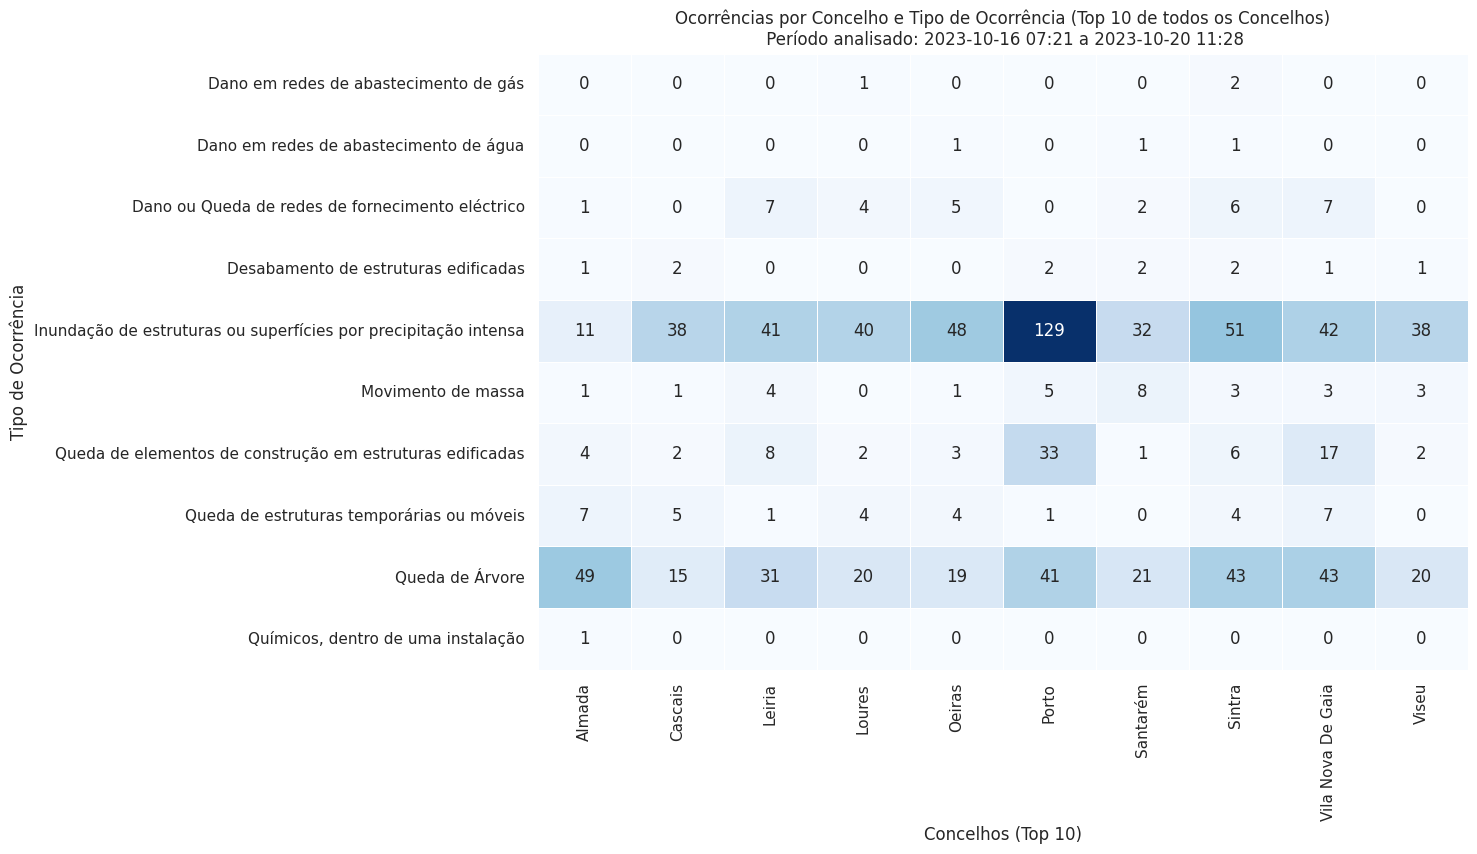

In [ ]:
# Calculate the top 10 most affected concelhos in the entire dataset
top_10_concelhos = incident_data_full['concelho'].value_counts().nlargest(10)

# Create a DataFrame to hold the top 10 concelhos and their counts
top_10_concelhos_df = top_10_concelhos.reset_index()
top_10_concelhos_df.columns = ['concelho', 'number_of_incidents']

# Create a DataFrame for the top 10 concelhos
top_10_concelhos_list = top_10_concelhos.index.tolist()
incident_data_top_10_concelhos = incident_data_full[incident_data_full['concelho'].isin(top_10_concelhos_list)]

# Create a crosstab to count the occurrences of natureza in the top 10 concelhos
natureza_concelho_crosstab = pd.crosstab(incident_data_top_10_concelhos['natureza'], incident_data_top_10_concelhos['concelho'])

# Create the heatmap
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(natureza_concelho_crosstab, annot=True, fmt="d", cmap='Blues', linewidths=.5, cbar=False)

# Set the labels and titles
plt.xlabel('Concelhos (Top 10)')
plt.ylabel('Tipo de Ocorrência')
plt.title(f'Ocorrências por Concelho e Tipo de Ocorrência (Top 10 de todos os Concelhos)\n Período analisado: {start_date_str} a {end_date_str}', loc='center')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Save the figure in high resolution
filename = f'heatmap_concelho_top10_natureza_{end_date_str}.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')
files.download(filename)
plt.show()

#### Occurrences by Parish for the most affected Municipality (Ocorrências por Freguesia para o Concelho mais afetado)

This code analyzes occurrence data to identify the county (concelho) with the highest number of occurrences. It first finds the concelho with the most occurrences and then filters the data for that specific concelho. Within this concelho, the code calculates the frequency of each occurrence type (natureza) for each parish (freguesia). After determining the top 10 occurrence types in the concelho, it creates a heatmap to visually display the frequency of these top occurrences across the parishes. The heatmap uses color intensity to indicate frequency differences, and numerical annotations provide specific counts. Custom labels and titles are used, emphasizing the most affected concelho and the analysis period. The final visualization is saved as a high-resolution image for download or future reference.


---


Este código analisa dados de ocorrências para identificar o concelho (concelho) com o maior número de ocorrências. Primeiro, descobre o concelho com mais ocorrências e depois filtra os dados para esse concelho específico. Dentro deste concelho, o código calcula a frequência de cada tipo de ocorrência (natureza) para cada freguesia (freguesia). Após determinar os 10 principais tipos de ocorrências no concelho, ele cria um mapa de calor para exibir visualmente a frequência dessas principais ocorrências nas freguesias. O mapa de calor usa a intensidade da cor para indicar diferenças de frequência, e anotações numéricas fornecem contagens específicas. Rótulos e títulos personalizados são usados, enfatizando o concelho mais afetado e o período de análise. A visualização final é salva como uma imagem de alta resolução para download ou referência futura.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

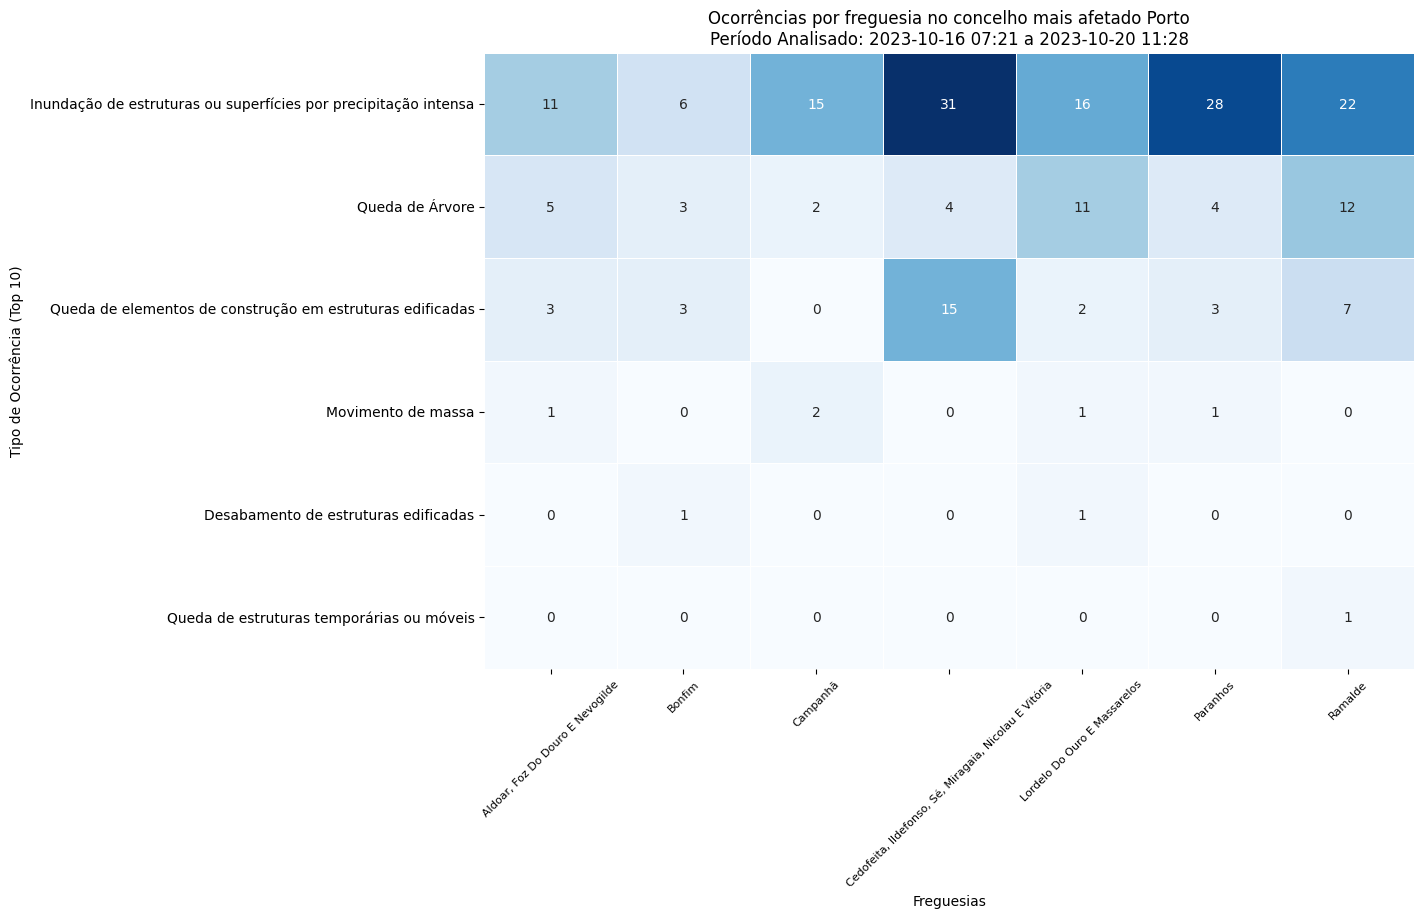

In [ ]:
# Identify the concelho with the most incidents across the entire dataset
top_concelho = incident_data_full['concelho'].value_counts().idxmax()

# Filter the data for that concelho
concelho_data = incident_data_full[incident_data_full['concelho'] == top_concelho]

# Calculate the frequency of each 'natureza' for each 'freguesia' in the top concelho
natureza_freguesia_crosstab = pd.crosstab(concelho_data['natureza'], concelho_data['freguesia'])

# Get the top 10 'natureza' types
top_naturezas_concelho = concelho_data['natureza'].value_counts().nlargest(10).index

# Filter the crosstab for only the top 10 'natureza' types
top_natureza_freguesia_crosstab = natureza_freguesia_crosstab.loc[top_naturezas_concelho]

# Create the heatmap
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(top_natureza_freguesia_crosstab, annot=True, fmt="d", cmap='Blues', linewidths=.5, cbar=False)

# Set the labels and titles with the top concelho
plt.xlabel('Freguesias')
plt.ylabel('Tipo de Ocorrência (Top 10)')
plt.title(f'Ocorrências por freguesia no concelho mais afetado {top_concelho}\nPeríodo Analisado: {start_date_str} a {end_date_str}', loc='center')
plt.xticks(rotation=45,fontsize=8)
plt.yticks(rotation=0)

# Save the figure in high resolution
filename=f'freguesia_high_res_{end_date_str}.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')
files.download(filename)
plt.show()

#### Interactive Heatmap for Occurences (Mapa Ocorrências Interactivo)

This code generates an interactive map to visualize different types of occurrences (natureza) in Portugal based on their geographical coordinates. It begins by creating a base map centered around Portugal, utilizing a dark theme from 'CartoDB dark_matter'. The map identifies unique natureza types from the dataset and prepares to create individual layers for each.

A blue gradient color scale is defined for visual consistency across the heatmap layers. For each unique natureza, the code filters the relevant data and extracts the latitude and longitude information to construct heatmaps. These heatmaps, indicating the concentration of occurrences, are added as separate layers to the base map, each corresponding to a different natureza.

Layer controls are implemented, allowing viewers to toggle between the different heatmap layers for a comparative analysis. The interactive map, complete with all the layers and controls, is saved as an HTML file for accessibility and sharing, and is also programmed to be displayed within the execution environment.


---


Este código gera um mapa interativo para visualizar diferentes tipos de ocorrências (natureza) em Portugal com base em suas coordenadas geográficas. Começa criando um mapa base centrado em Portugal, utilizando um tema escuro de 'CartoDB dark_matter'. O mapa identifica tipos únicos de natureza a partir do conjunto de dados e cria camadas individuais para cada um.

Uma escala de cores com gradiente azul é definida para consistência visual nas camadas do mapa de calor. Para cada natureza única, o código filtra os dados relevantes e extrai as informações de latitude e longitude para construir mapas de calor. Esses mapas de calor, indicando a concentração de ocorrências, são adicionados como camadas separadas ao mapa base, cada um correspondendo a uma diferente natureza.

Controles de camada são implementados, permitindo que os utilizadores alternem entre as diferentes camadas de mapa de calor para uma análise comparativa. O mapa interativo, completo com todas as camadas e controles, é salvo como um arquivo HTML para acessibilidade e compartilhamento, e também está programado para ser exibido dentro do ambiente de execução.

In [ ]:
# Create a base map with a dark theme
map = folium.Map(location=[39.3999, -8.2245], zoom_start=6, tiles='CartoDB dark_matter')  # coordinates for Portugal

# List of 'natureza' to create layers for
naturezas = incident_data_full['natureza'].unique()

# Layer control
layer_control = folium.LayerControl(collapsed=False)

# Define a blue gradient color scale
gradient = {0.2: 'blue', 0.4: 'deepskyblue', 0.6: 'cyan', 0.8: 'aqua', 1.0: 'white'}

# Create a heatmap layer for each 'natureza'
for natureza in naturezas:
    filtered_data = incident_data_full[incident_data_full['natureza'] == natureza]
    heat_data = [[row['lat'], row['lng']] for index, row in filtered_data.iterrows()]
    heat_layer = HeatMap(heat_data, name=natureza, show=False, gradient=gradient,radius=10)
    heat_layer.add_to(map)

# Add layer control to the map
layer_control.add_to(map)

# Save it to a file
filename=f'heatmap_map_natureza_layers_dark_{end_date_str}.html'
map.save(filename)
files.download(filename)
# Display the map
map

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Honeycomb Hexagonal Map (Mapa Hexagonal)

This code analyzes occurrence data across different districts in Portugal by visualizing the data on a hexagonal grid map. It begins by downloading a shapefile containing district boundaries from a specified URL and extracts this data for use. The code then loads and processes the geographical data, excluding specific regions and ensuring the correct Coordinate Reference System (CRS) is used.

Hexagons are generated to represent districts, and occurrence data is aggregated by district and merged with the hexagon geodataframe. The visualization is created on a dark-themed map, with hexagons colored according to the total count of occurrences, using a blue color scheme. The map is customized for readability and aesthetics, including a specific title and a dark background. The final map is saved as a high-resolution image for sharing or further use.


---


Este código analisa dados de ocorrências em diferentes distritos de Portugal, visualizando os dados em um mapa de grade hexagonal. Ele começa baixando um shapefile contendo limites de distritos de uma URL específica e extrai esses dados para uso. O código então carrega e processa os dados geográficos, excluindo regiões específicas e garantindo que o Sistema de Referência de Coordenadas (CRS) correto seja usado.

Hexágonos são gerados para representar distritos, e os dados de ocorrência são agregados por distrito e mesclados com o geodataframe hexagonal. A visualização é criada em um mapa com tema escuro, com hexágonos coloridos de acordo com a contagem total de ocorrências, usando um esquema de cores azul. O mapa é personalizado para legibilidade e estética, incluindo um título específico e um fundo escuro. O mapa final é salvo como uma imagem de alta resolução para compartilhamento ou uso posterior.

In [ ]:
# Fetch the shapefile from dados.gov.pt

# URL of the zip file (Source dados.gov.pt)
url = 'https://dados.gov.pt/s/resources/distritos-de-portugal/20181112-193106/distritos-shapefile.zip'

# Path for the sample_data folder
sample_data_folder = 'sample_data'
os.makedirs(sample_data_folder, exist_ok=True)  # create directory if it doesn't exist

# Fetch the zip file
response = requests.get(url, stream=True)

# Check if the request was successful
if response.status_code == 200:
    # Full path for the zip file
    zip_file_path = os.path.join(sample_data_folder, 'file.zip')

    # Save the zip file to the specified path
    with open(zip_file_path, 'wb') as zip_file:
        shutil.copyfileobj(response.raw, zip_file)

    # Extract the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(sample_data_folder)

    # You can now work with the files in sample_data_folder
    print(f'The extracted files are located in: {sample_data_folder}')
else:
    print('Failed to download file, status code:', response.status_code)

The extracted files are located in: sample_data


In [ ]:
# Please upload the font you wish to use to sample_data

# Path to your custom font
font_path = '/content/sample_data/ADLaMDisplay-Regular.ttf'

# Create a FontProperties object and set the font properties
font_properties = FontProperties(fname=font_path, size=16)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

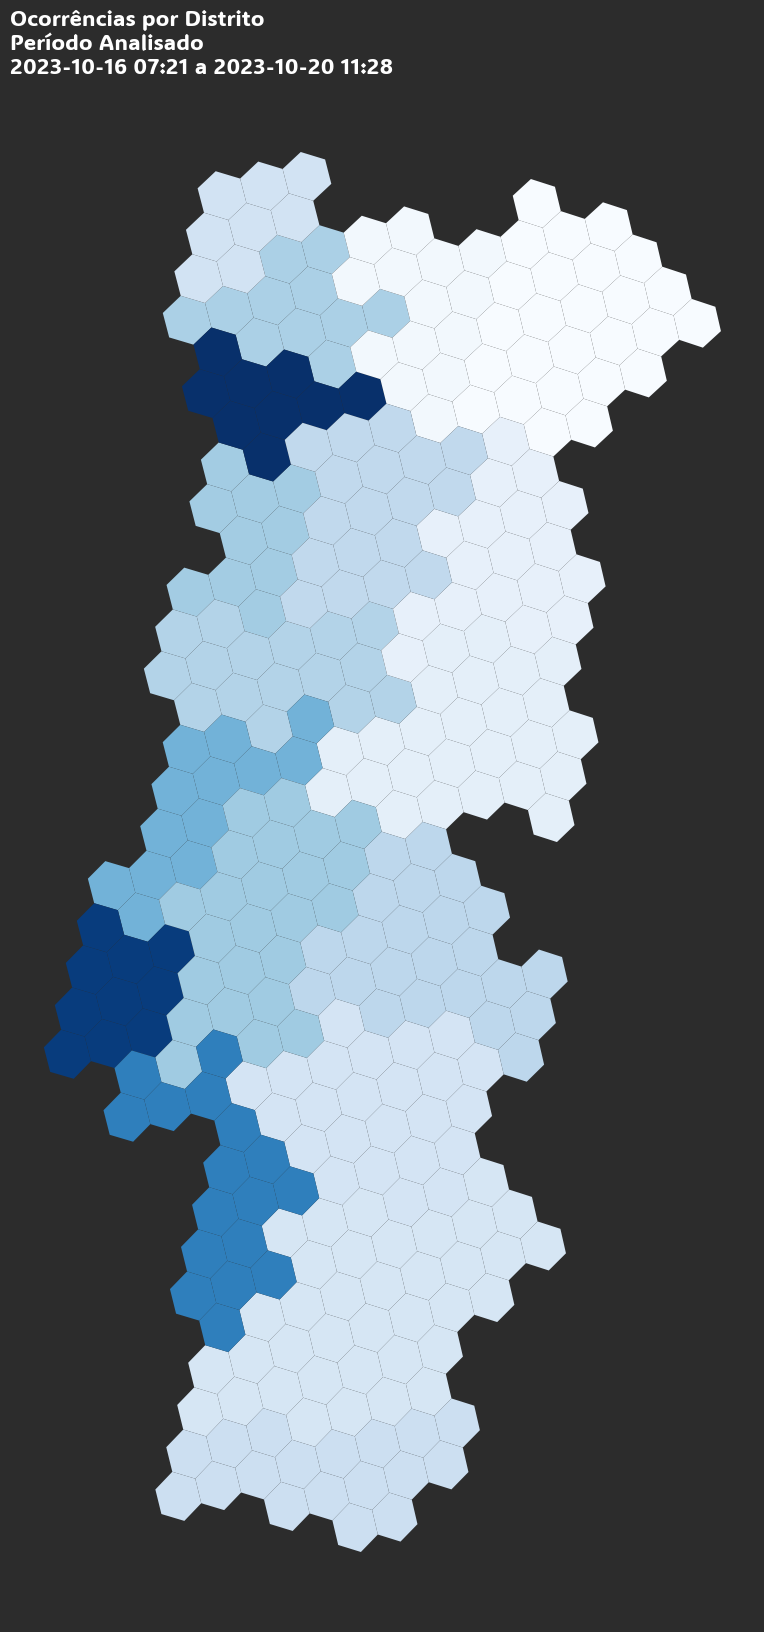

In [ ]:
# Debug import
from google.colab import files

# Load and inspect the district shapefile
districts_gdf = gpd.read_file('/content/sample_data/distritos.shp')
# Exclude rows where 'TYPE_1' is 'Regiões autônomas'
districts_gdf = districts_gdf[districts_gdf['TYPE_1'] != 'Regiões autônomas']
# define the size of the hexagons
resolution = 5
# if it's not set or incorrect, set to the correct CRS (assuming EPSG:4326 here)
districts_gdf = districts_gdf.set_crs("EPSG:4326", allow_override=True)
# Create the Hexagons
hexagons = districts_gdf.h3.polyfill_resample(resolution)

# Create dataframe that counts the numnber of occurrences per district
total_incidents_by_district = data.groupby('district').size().reset_index(name='total_incident_count')

# Create uniformity between District Names
hexagons['district'] = hexagons['NAME_1'].str.upper().apply(unidecode.unidecode)
total_incidents_by_district['district'] = total_incidents_by_district['district'].str.upper().apply(unidecode.unidecode)

# Now, you should be able to merge and plot as previously described
merged_gdf = hexagons.merge(total_incidents_by_district, on='district', how='left')

# Replace NaNs with 0s (assuming that NaN means no incidents)
merged_gdf['total_incident_count'] = merged_gdf['total_incident_count'].fillna(0)


# Create the plot with a large figure size
fig, ax = plt.subplots(1, 1, figsize=(20, 20))  # You can adjust the size as needed

# Set a dark grey background color
fig.patch.set_facecolor('#2c2c2c')
ax.set_facecolor('#2c2c2c')

# Plot the hexagons, colored by total_incident_count using a blue color scheme
merged_gdf.plot(column='total_incident_count', ax=ax, cmap='Blues', legend=False)

# Remove axes for a cleaner look
ax.set_axis_off()
# Set the title with white color and custom font
plt.title(f'Ocorrências por Distrito\nPeríodo Analisado\n{start_date_str} a {end_date_str}',
          loc='left',
          color='white',
          fontproperties=font_properties)
# Save the figure with high resolution

filename=f'pt_hexagonal_{end_date_str}.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')
files.download(filename)

# Show the plot
plt.show()



## Time Analysis (Análise Temporal)

**This block generates a set of graphics focused on the dataset's time frame**

**Results may vary based on the time period in your dataset**



---

**Este bloco gera um conjunto de gráficos focados no período do conjunto de dados**

**Os resultados podem variar com base no período temporal do teu conjunto de dados**

#### Daily Number of Occurences (Número de Ocorrências diárias)

This code analyzes occurrence data by date, aiming to understand the daily distribution and average trends of occurrences. It extracts the date from the datetime information and groups the data by this date, calculating the total number of occurrences for each day. The script then computes the average number of daily occurrences.

A time series plot is created to visualize the daily counts. The plot is styled with a dark grid, and the data is represented as a blue line chart. An average line is drawn on the plot in red dashed style, indicating the average daily occurrences over the analyzed period. The chart is enhanced with a title, axis labels, and a legend, and the x-axis tick labels are rotated for better readability. The layout is adjusted to fit all elements neatly, and the final plot is saved as a high-resolution image for sharing or further use.


---


Este código analisa dados de ocorrências por data, com o objetivo de entender a distribuição diária e as tendências médias de ocorrências. Extrai a data das informações de data e hora e agrupa os dados por esta data, calculando o número total de ocorrências para cada dia. O script então calcula a média do número de ocorrências diárias.

Um gráfico de séries temporais é criado para visualizar as contagens diárias. O gráfico é estilizado com uma grade escura, e os dados são representados como um gráfico de linha azul. Uma linha média é desenhada no gráfico em estilo tracejado vermelho, indicando as ocorrências diárias médias durante o período analisado. O gráfico é aprimorado com um título, rótulos de eixo e uma legenda, e os rótulos de marcação do eixo x são rotacionados para melhor legibilidade. O layout é ajustado para acomodar todos os elementos de forma ordenada, e o gráfico final é salvo como uma imagem de alta resolução para compartilhamento ou uso posterior.


---



**In the future this average will be generated based on a fixed sample of the last 5 years, per month**

**No futuro esta média será gerada baseada numa amostra fixa dos últimos 5 anos, por mês**



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

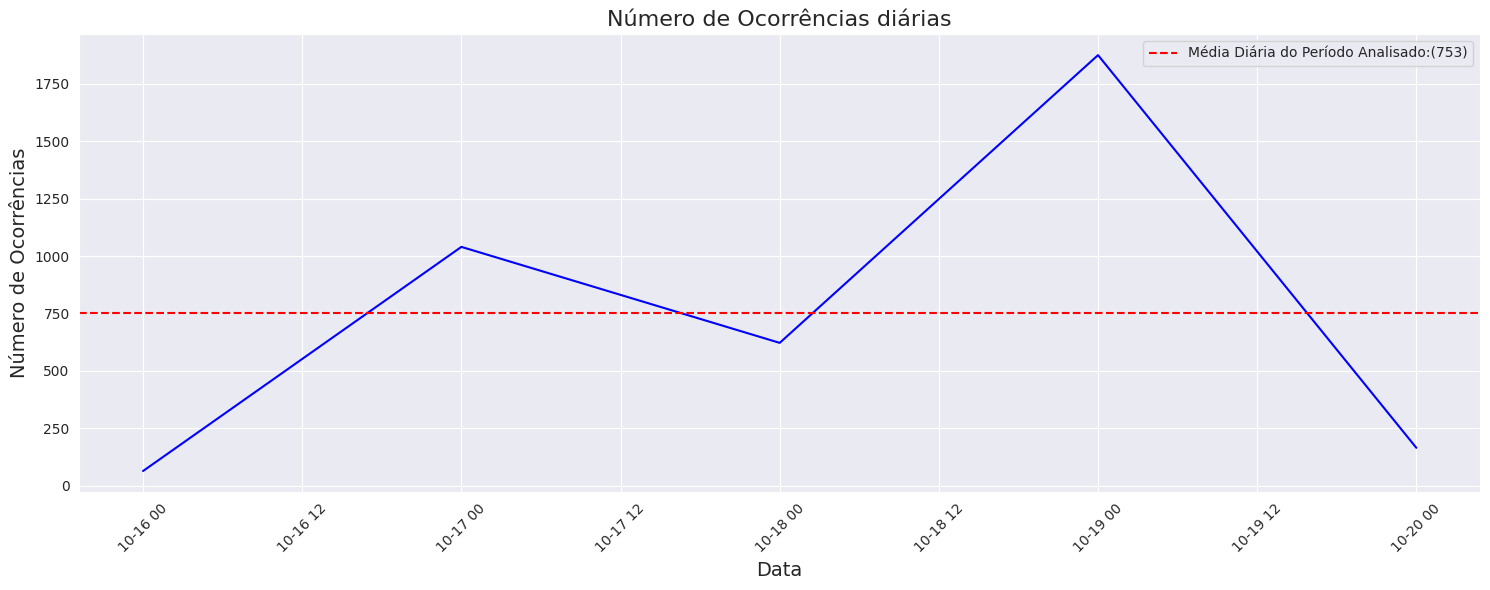

In [ ]:
incident_data_full = data

# Extract date from datetime for daily analysis
incident_data_full['date'] = incident_data_full['date_time'].dt.date

# Group the data by date and count the number of incidents for each day
daily_counts = incident_data_full.groupby('date').size()

# Calculate the average number of incidents per day
average_daily_incidents = daily_counts.mean()

# Create a time series plot
plt.figure(figsize=(15, 6))
sns.set_style("darkgrid")
sns.lineplot(x=daily_counts.index, y=daily_counts, color="blue")
plt.axhline(y=average_daily_incidents, color='red', linestyle='--', label=f'Média Diária do Período Analisado:({average_daily_incidents:.0f})')
plt.title("Número de Ocorrências diárias", fontsize=16)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Número de Ocorrências", fontsize=14)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Save the figure
filename=f'incidents_over_time_with_daily_average_{end_date_str}.png'
plt.savefig(filename, dpi=300,bbox_inches='tight')
files.download(filename)
plt.show()

#### Table of Occurences by weekday and hour ( Tabela de Ocorrências por dia da semana e hora)

**This code processes timestamp data, extracting the hour and the day of the week from a 'date_time' column in a DataFrame. It then creates a cross-tabulation (crosstab) between these extracted values, resulting in a tabular representation of incident counts organized by hour and day of the week. The code also includes mapping of day names to Portuguese for readability and orders the days correctly. The primary output is a heatmap visualization generated using Seaborn, showcasing the distribution of incidents across days of the week and hours of the day. Labels, titles, and annotations are added for context, and the resulting heatmap is saved as a high-resolution image, ready for sharing or further analysis, with the filename reflecting the end date of the analyzed period.**



---

**Este código processa dados de via data/hora, extraindo a hora e o dia da semana de uma coluna 'date_time' em um DataFrame. Em seguida, cria uma tabulação cruzada (crosstab) entre esses valores extraídos, resultando em uma representação tabular das contagens de ocorrências organizadas por hora e dia da semana. O código também inclui mapeamento de nomes de dias para português para facilitar a leitura e ordenar os dias corretamente. O resultado principal é uma visualização de mapa de calor gerada usando Seaborn, mostrando a distribuição de incidentes entre os dias da semana e horas do dia. Rótulos, títulos e anotações são adicionados para contextualizar, e o mapa de calor resultante é salvo como uma imagem de alta resolução, pronta para partilha ou análise posterior, com o nome do arquivo refletindo a data de término do período analisado.**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

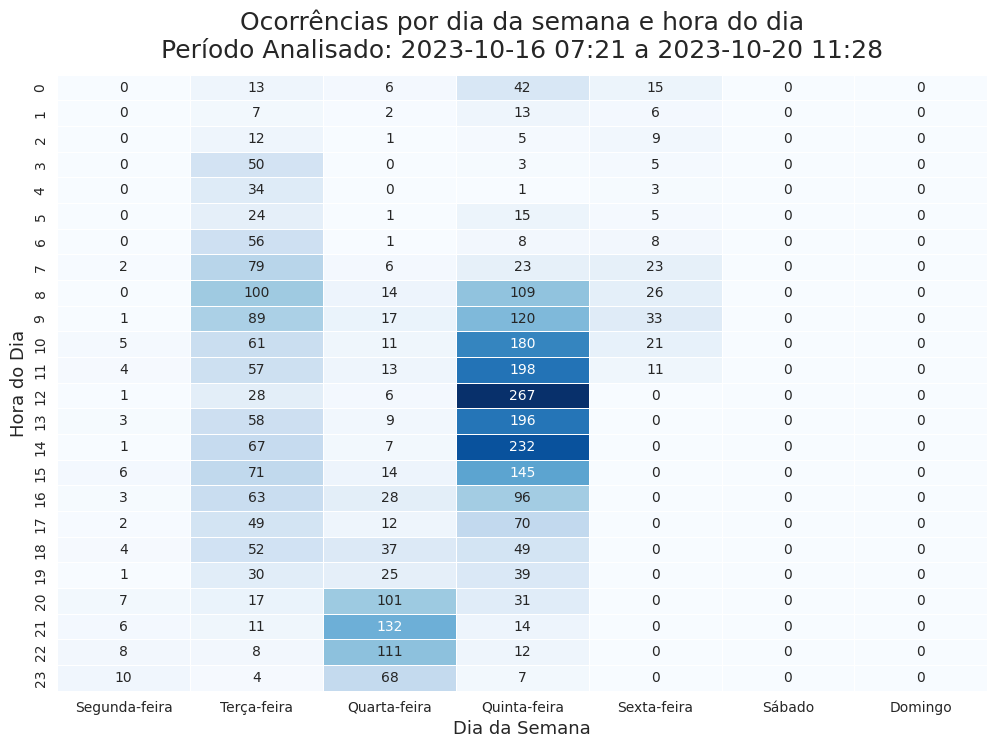

In [ ]:
# Extract the hour and the day of the week
data['hour'] = data['date_time'].dt.hour
data['day_of_week'] = data['date_time'].dt.day_name()

# Create a crosstab of hour and day of the week
heatmap_data = pd.crosstab(data['hour'], data['day_of_week'])

# Portuguese days mapping
days_portuguese = {
    "Monday": "Segunda-feira",
    "Tuesday": "Terça-feira",
    "Wednesday": "Quarta-feira",
    "Thursday": "Quinta-feira",
    "Friday": "Sexta-feira",
    "Saturday": "Sábado",
    "Sunday": "Domingo"
}
data['day_of_week_pt'] = data['day_of_week'].map(days_portuguese)

# Create a pivot table for the heatmap data
heatmap_data = data.pivot_table(index='hour', columns='day_of_week_pt', values='id', aggfunc='count', fill_value=0)

# Sort the days of the week in Portuguese
ordered_days = ["Segunda-feira", "Terça-feira", "Quarta-feira", "Quinta-feira", "Sexta-feira", "Sábado", "Domingo"]


# Ensure all days are present in the heatmap, even if there's no data for them
for day in ordered_days:
    if day not in heatmap_data.columns:
        heatmap_data[day] = 0
heatmap_data = heatmap_data[ordered_days]  # ensure columns are ordered correctly

# Create the heatmap
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt="g", linewidths=.5,cbar=False)
heatmap.set_title(f'Ocorrências por dia da semana e hora do dia\nPeríodo Analisado: {start_date_str} a {end_date_str}', fontdict={'fontsize': 18}, pad=12)
heatmap.set_xlabel('Dia da Semana', fontsize=13)
heatmap.set_ylabel('Hora do Dia', fontsize=13)
filename=f'incidents_by_day_week_{end_date_str}.png'
plt.savefig(filename, dpi=300,bbox_inches='tight')
files.download(filename)
plt.show()

#### Number of Occurences by Type (Número de Ocorrências por Tipo) - Top 20

**This code segment calculates and visualizes the counts of each incident type within a dataset. It generates a bar chart to represent the top 20 incident types based on their frequency, with the option to adjust the number of types shown. The chart is styled with a white background and a blue color palette for the bars. Labels, titles, and axes are included for clarity, enhancing interpretability. The layout is fine-tuned, and unnecessary spines are removed. Finally, the resulting bar chart is saved as a high-resolution image, named 'bar_chart_incidents_{end_date_str}.png,' indicating the end date of the analysis period, facilitating sharing or further analysis of incident type distribution during the specified timeframe.**



---
**Este segmento de código calcula e visualiza as contagens de cada tipo de incidente no conjunto de dados. Gera um gráfico de barras para representar os 20 principais tipos de incidentes com base na sua frequência, com a opção de ajustar o número de tipos mostrados. O gráfico tem um fundo branco e uma paleta de cores azul para as barras. Rótulos, títulos e eixos são incluídos para maior clareza, melhorando a interpretabilidade. O layout é ajustado e lombadas desnecessárias são removidas. Por fim, o gráfico de barras resultante é salvo como uma imagem de alta resolução, denominada 'bar_chart_incidents_{end_date_str}.png,' indicando a data final do período de análise, facilitando a partilha, arquivo, ou análise adicional da distribuição do tipo de incidente durante o período especificado.**


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

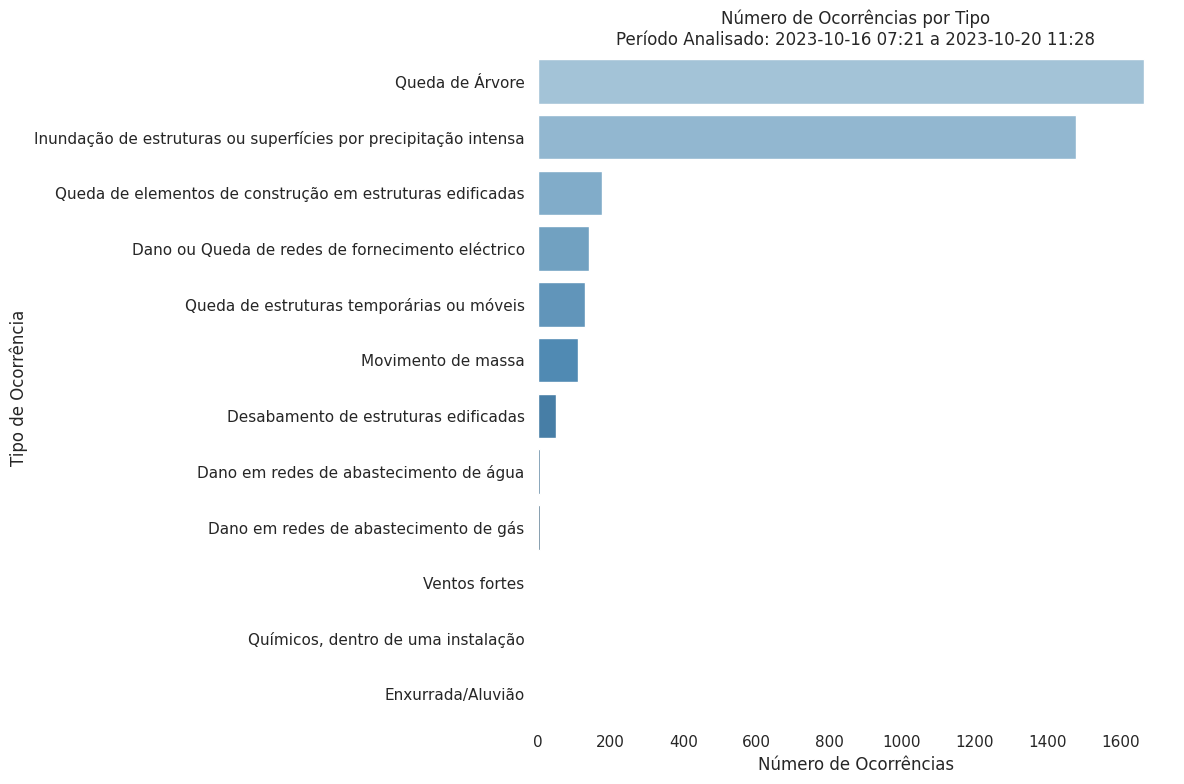

In [ ]:
# Count the number of each type of incident. The number in head can be modified to show more, or less, types of occurrence
incident_counts = incident_data_full['natureza'].value_counts().head(20)
# Set the background style
sns.set(style="white")
# Create a bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x=incident_counts.values, y=incident_counts.index, palette="Blues_d")
plt.title(f'Número de Ocorrências por Tipo\nPeríodo Analisado: {start_date_str} a {end_date_str}')
plt.xlabel('Número de Ocorrências')
plt.ylabel('Tipo de Ocorrência')
# Adjust the layout
plt.tight_layout()
# Remove the spines
sns.despine(left=True, bottom=True)
# Save and show the graph
filename=f'bar_chart_incidents_{end_date_str}.png'
plt.savefig(filename, dpi=300,bbox_inches='tight')
files.download(filename)
plt.show()

#### Number of Occurrences by District and Type of Occurrence (Número de Ocorrências por Distrito e por Tipo de Ocorrência) - Top 10


This code segment identifies the top 10 most common incident types within the dataset by counting their occurrences and subsequently filters the data to include only these top types. It then generates a stacked bar chart displaying the distribution of these top 10 incident types across different districts. The chart employs a 'viridis' colormap, clearly illustrating the variations in incident types within districts. Appropriately titled and labeled, the chart also includes a legend for incident type differentiation. To facilitate sharing and further analysis, the resulting stacked bar chart is saved as a high-resolution image with a filename denoting the end date of the analysis period. This image offers valuable insights into the prevalence of the top incident types across districts during the specified timeframe.


---

**Este segmento de código identifica os 10 tipos de incidentes mais comuns no conjunto de dados através da contagem das suas ocorrências e, subsequentemente, filtra os dados para incluir apenas estes tipos principais. Em seguida, gera um gráfico de barras empilhadas que apresenta a distribuição destes 10 tipos de incidentes mais comuns em diferentes distritos. O gráfico utiliza um mapa de cores "viridis", ilustrando claramente as variações dos tipos de incidentes nos distritos. Com títulos e etiquetas apropriados, o gráfico também inclui uma legenda para diferenciação dos tipos de incidentes. Para facilitar a partilha e a análise posterior, o gráfico de barras empilhadas resultante é guardado como uma imagem de alta resolução com um nome de ficheiro que indica a data final do período de análise. Esta imagem oferece informações valiosas sobre a prevalência dos principais tipos de incidentes nos distritos durante o período de tempo especificado.**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

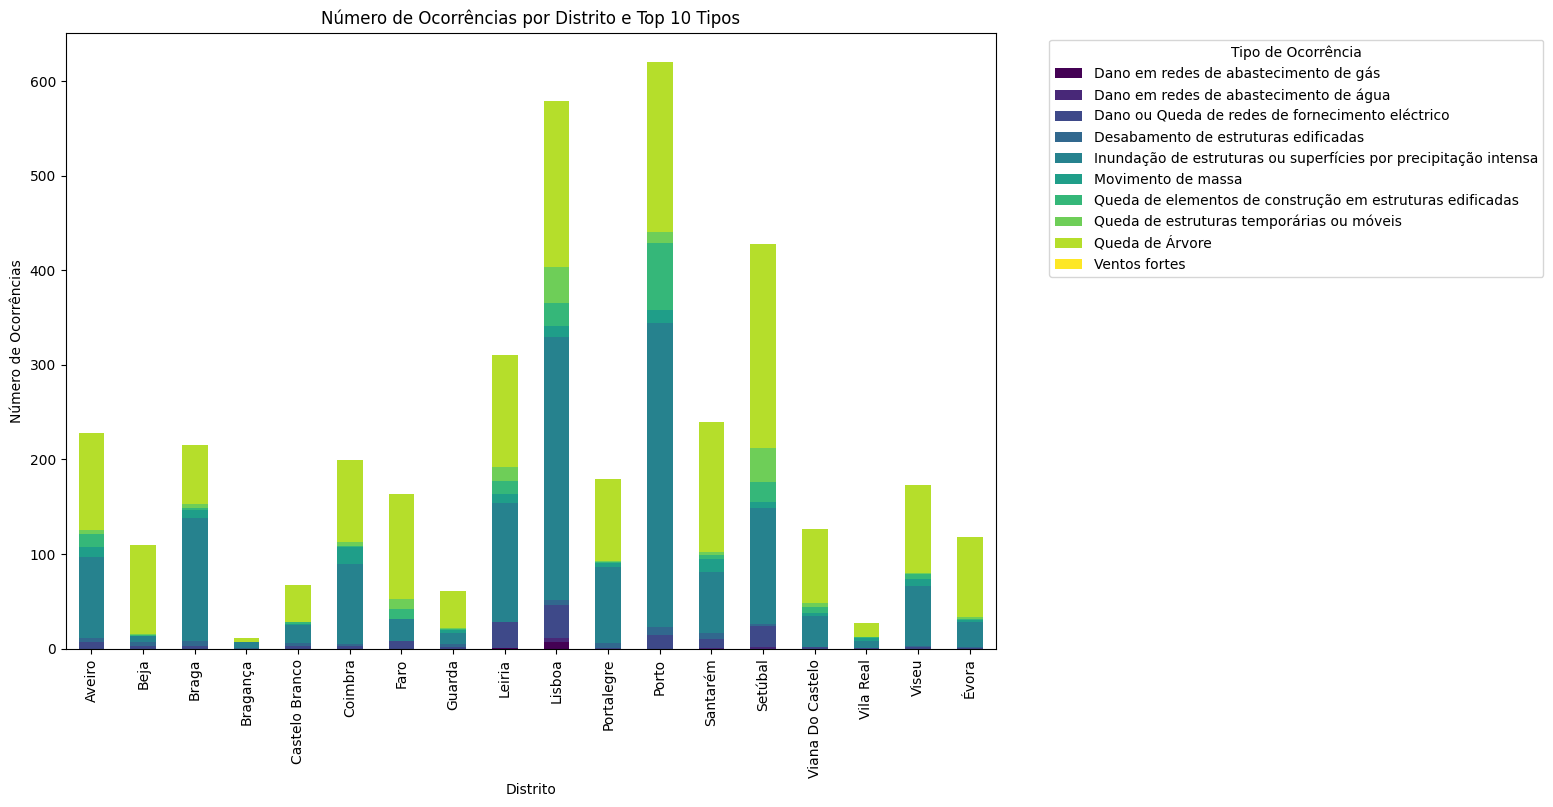

In [ ]:
# Copy data dataframe for integrity purposes
incident_data_full = data
# Select the top 10 most common incident types
top_10_incidents = incident_data_full['natureza'].value_counts().nlargest(10)

# Filter the data to include only the top 10 incident types
top_10_incident_types = incident_data_full[incident_data_full['natureza'].isin(top_10_incidents.index)]

# Create a crosstab of district and top 10 incident types
district_type_ct = pd.crosstab(top_10_incident_types['district'], top_10_incident_types['natureza'])

# Create a stacked bar chart for the top 10 incidents
district_type_ct.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.title('Número de Ocorrências por Distrito e Top 10 Tipos')
plt.xlabel('Distrito')
plt.ylabel('Número de Ocorrências')
plt.legend(title='Tipo de Ocorrência', bbox_to_anchor=(1.05, 1), loc='upper left')
filename=f'stacked_bar_district_and_type_{end_date_str}.png'
plt.savefig(filename, dpi=300,bbox_inches='tight')
files.download(filename)
plt.show()

### Response Times (Tempos de Resposta)

**In this code snippet, Unix timestamps in the 'created.sec' and 'updated.sec' columns of the occurrence dataset are converted into standard datetime format, yielding 'created_datetime' and 'updated_datetime' columns. Subsequently, it calculates response times in minutes for each occurrence by computing the time elapsed between 'updated_datetime' and 'created_datetime.' Additionally, the code filters rows in the dataset based on the 'status' column, retaining those with 'Conclusão' (completed occurrences) and 'Chegada ao TO' (indicating arrival at the occurrence location). These filtered subsets, 'closed_incidents' and 'response_incidents,' will be used in the next code blocks**



---

**Neste trecho de código, os carimbos de data/hora Unix nas colunas 'created.sec' e 'updated.sec' do conjunto de dados de ocorrência são convertidos no formato datetime padrão, produzindo as colunas 'created_datetime' e 'updated_datetime'. Em seguida, calcula os tempos de resposta em minutos para cada ocorrência, calculando o tempo decorrido entre 'updated_datetime' e 'created_datetime'. Adicionalmente, o código filtra as linhas do conjunto de dados com base na coluna 'status', retendo aquelas com 'Conclusão' (ocorrências concluídas) e 'Chegada ao TO' (indicando a chegada ao local da ocorrência). Estes subconjuntos filtrados, 'incidentes_encerrados' e 'incidentes_resposta', serão utilizados nos próximos blocos de código**


In [ ]:
# Convert 'created.sec' and 'updated.sec' from Unix time to regular datetime
incident_data_full['created_datetime'] = pd.to_datetime(incident_data_full['created.sec'], unit='s')
incident_data_full['updated_datetime'] = pd.to_datetime(incident_data_full['updated.sec'], unit='s')

# Calculate the response time in minutes
incident_data_full['response_time'] = (incident_data_full['updated_datetime'] - incident_data_full['created_datetime']).dt.total_seconds() / 60.0  # convert to minutes


In [ ]:
# Filter rows where 'status' is 'Conclusão'
closed_incidents = incident_data_full.loc[incident_data_full['status'] == 'Conclusão']
# Filter rows where 'status' is 'Chegada ao TO'
response_incidents = incident_data_full.loc[incident_data_full['status'] == 'Chegada ao TO']

#### Box Plots (Diagrama de Caixa)


**This code segment generates two box plots to provide insights into occurrence data. The first box plot represents the distribution of Occurrence Duration, calculated as the difference between 'created.sec' and 'updated.sec' for occurrences marked as 'Completion.'**

**The second box plot visualizes Response Time, computed as the difference between 'created.sec' and 'updated.sec' for occurrences labeled 'Arrival at TO.'**

**The code sets the style and color palette, configures plot size, and defines boxplot attributes. Titles and labels are added for clarity, gridlines assist in interpretation, and the box around the plot is removed for simplicity. Both box plots are saved as images, facilitating further analysis and sharing of insights.**

#### Definitions

**Occurrence Duration**: difference between `created.sec` and `updated.sec` for all occurrences with status = `Conclusão`

Response Time: difference between created.sec and updated.sec for all events with status = `Chegada ao TO`


---
**Este segmento de código gera dois diagaramas de caixa para fornecer informações sobre os dados de ocorrência. O primeiro diagrama de caixa representa a distribuição da Duração da ocorrência, calculada como a diferença entre `created.sec` e 'updated.sec' para ocorrências marcadas como `Conclusão`.**

**O segundo diagrama de caixa visualiza o Tempo de resposta, calculado como a diferença entre `created.sec` e `updated.sec` para ocorrências marcadas como `Chegada ao TO`.**

**O código define o estilo e a paleta de cores, configura o tamanho do gráfico e define os atributos do boxplot.Os títulos e as etiquetas são adicionados para maior clareza, as linhas de grelha ajudam na interpretação e a caixa à volta do gráfico é removida para simplificar. Ambos os gráficos de caixa são guardados como imagens facilitando a análise posterior e a partilha.**

#### Definições

**Duração da Ocorrência**: diferença entre `created.sec` e `updated.sec` para todas as ocorrências com `status` = `Conclusão`

**Tempo de Reposta**: diferença entre `created.sec` e `updated.sec` para todas as ocorrências com `status` = `Chegada ao TO`


##### Occurrence Duration (Duração das Ocorrências)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

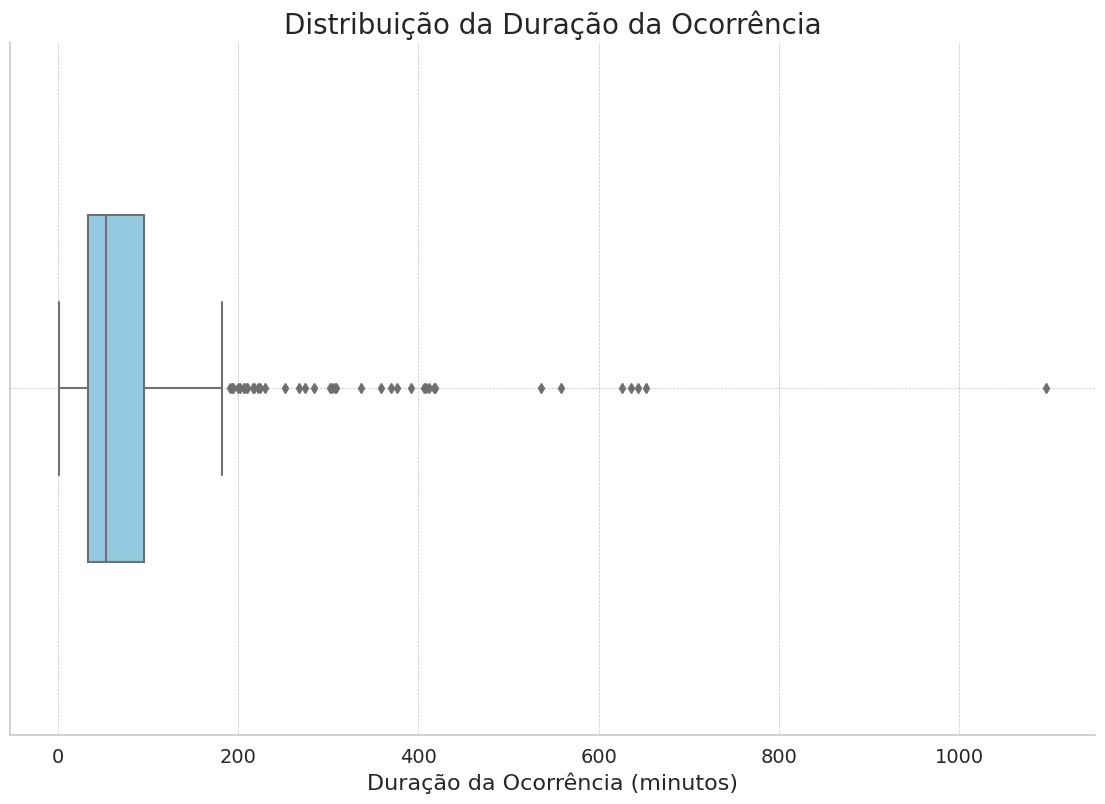

In [ ]:
# Box plot for response times
# Set style and color scheme
sns.set_style("whitegrid")
sns.set_palette("pastel")

# Create a larger plot
plt.figure(figsize=(14, 9))

# Create the boxplot with enhanced aesthetics
sns.boxplot(x=closed_incidents['response_time'], width=0.5, color="skyblue")

# Add a title and labels with larger fonts for clarity
plt.title('Distribuição da Duração da Ocorrência', fontsize=20)
plt.xlabel('Duração da Ocorrência (minutos)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show gridlines for easier interpretation
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Remove the box around the plot to simplify the visuals (optional)
sns.despine()
#Save the plot
filename=f'box_response_time_{end_date_str}.png'
plt.savefig(filename, dpi=300)
files.download(filename)
# Show the plot
plt.show()

##### Response Time (Tempo de Resposta)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

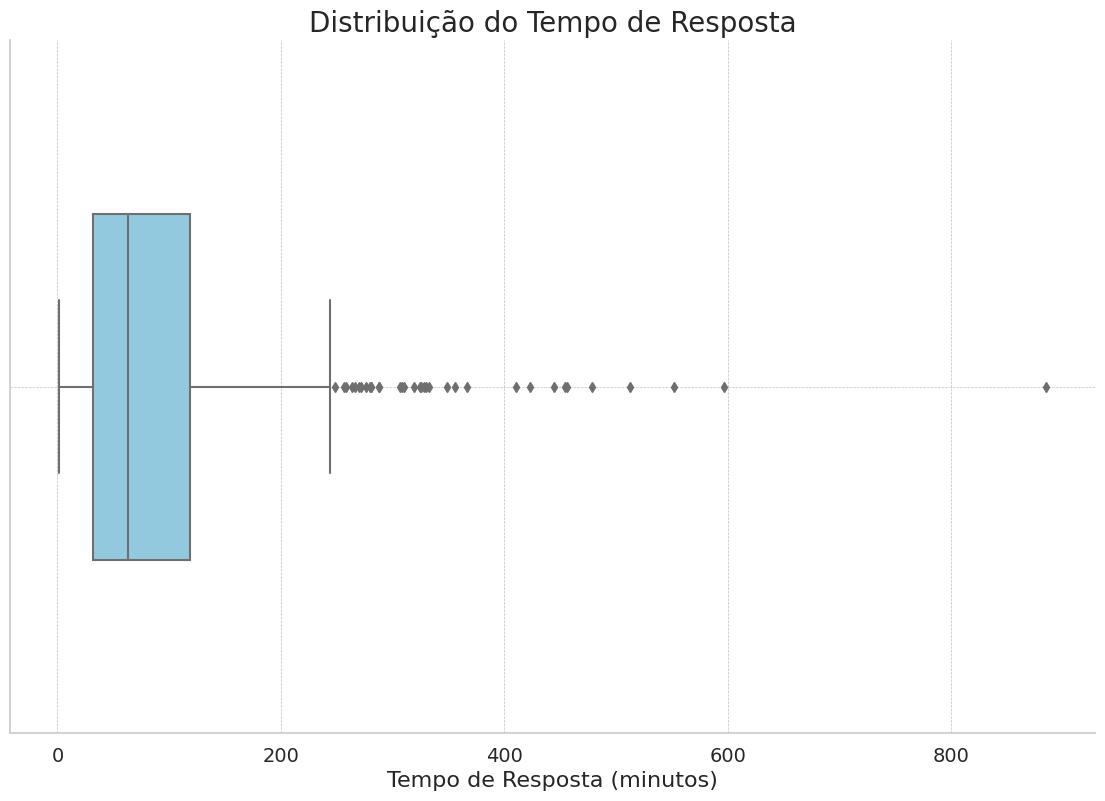

In [ ]:
# Box plot for response times
# Set style and color scheme
sns.set_style("whitegrid")
sns.set_palette("pastel")

# Create a larger plot
plt.figure(figsize=(14, 9))

# Create the boxplot with enhanced aesthetics
sns.boxplot(x=response_incidents['response_time'], width=0.5, color="skyblue")

# Add a title and labels with larger fonts for clarity
plt.title('Distribuição do Tempo de Resposta', fontsize=20)
plt.xlabel('Tempo de Resposta (minutos)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show gridlines for easier interpretation
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Remove the box around the plot to simplify the visuals (optional)
sns.despine()
#Save the plot
plt.savefig('box_response_time.png', dpi=300)
files.download('box_response_time.png')
# Show the plot
plt.show()

#### Histogram (Histograma)

**This code segment generates two histograms to provide insights into occurrence data. The first histogram represents the distribution of Occurrence Duration, calculated as the difference between `created.sec` and `updated.sec` for occurrences marked as `Conclusão`**

The second histogram visualizes Response Time, computed as the difference between `created.sec` and `updated.sec` for occurrences labeled `Chegada ao TO`.

**The code sets the style and color palette, configures plot size, and defines the histogram attributes. Titles and labels are added for clarity, gridlines assist in interpretation, and the box around the plot is removed for simplicity. Both histograms are saved as images, facilitating further analysis and sharing of insights.**

#### Definitions

**Occurrence Duration**: difference between `created.sec` and `updated.sec` for all occurrences with status = `Conclusão`

Response Time: difference between created.sec and updated.sec for all events with status = `Chegada ao TO`


---
**Este segmento de código gera dois histogramas para fornecer informações sobre os dados de ocorrência. O primeiro histograma representa a distribuição da Duração da ocorrência, calculada como a diferença entre `created.sec` e 'updated.sec' para ocorrências marcadas como `Conclusão`.**

**O segundo histograma visualiza o Tempo de resposta, calculado como a diferença entre `created.sec` e `updated.sec` para ocorrências marcadas como `Chegada ao TO`.**

**O código define o estilo e a paleta de cores, configura o tamanho do gráfico e define os atributos do histograma. Os títulos e as etiquetas são adicionados para maior clareza, as linhas de grelha ajudam na interpretação e a caixa à volta do gráfico é removida para simplificar. Ambos os hisogramas são guardados como imagens facilitando a análise posterior e a partilha.**

#### Definições

**Duração da Ocorrência**: diferença entre `created.sec` e `updated.sec` para todas as ocorrências com `status` = `Conclusão`

**Tempo de Reposta**: diferença entre `created.sec` e `updated.sec` para todas as ocorrências com `status` = `Chegada ao TO`



#####  Histogram for Occurence Duration (Histograma para Duração das Ocorrências)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

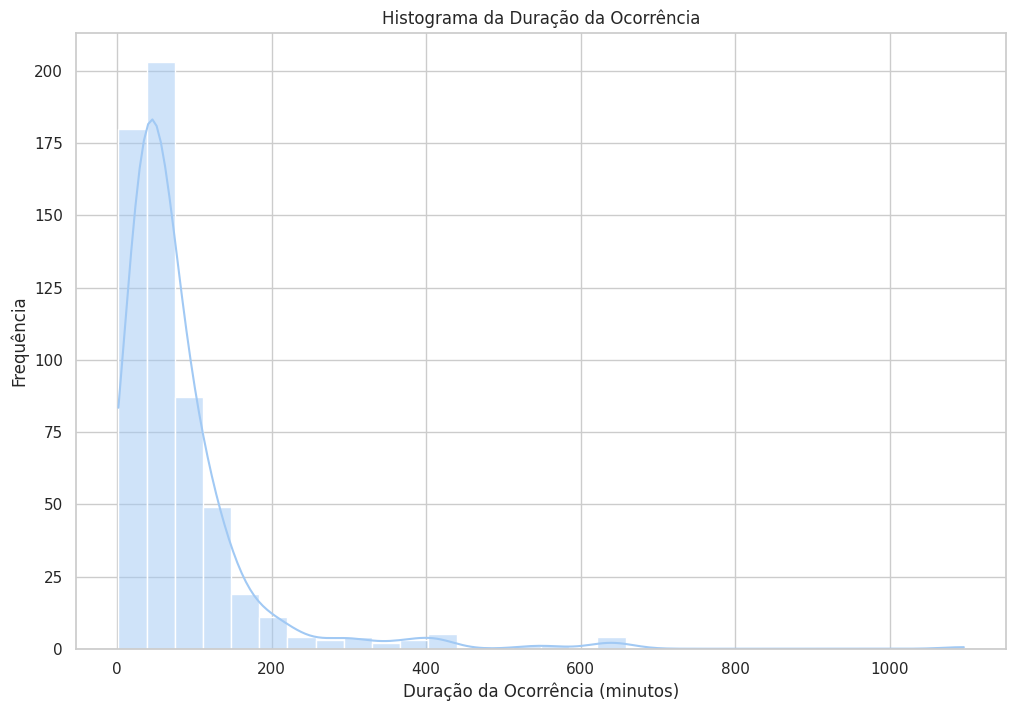

In [ ]:
# Histogram for Occurence Duration
plt.figure(figsize=(12, 8))
sns.histplot(closed_incidents['response_time'], bins=30, kde=True)
plt.title('Histograma da Duração da Ocorrência')
plt.xlabel('Duração da Ocorrência (minutos)')
plt.ylabel('Frequência')
#Save and show the histogram
filename=f'histogram_response_time_{end_date_str}.png'
plt.savefig(filename, dpi=300)
files.download(filename)
plt.show()

##### Histogram for Response Times (Histograma para tempos de Resposta)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

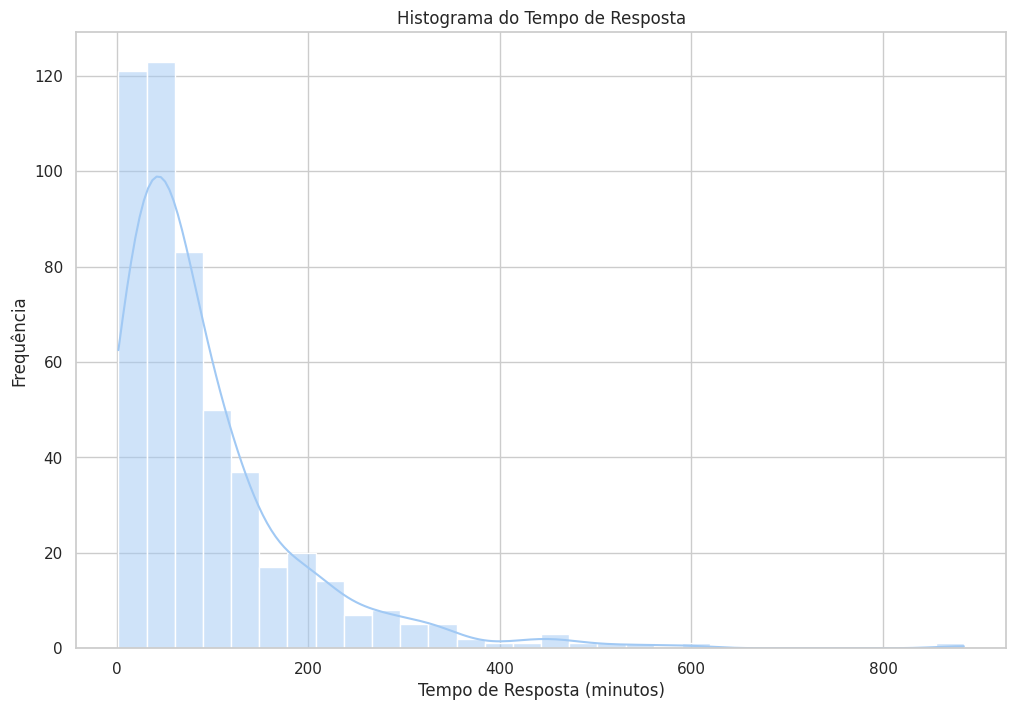

In [ ]:
# Histogram for response times
plt.figure(figsize=(12, 8))
sns.histplot(response_incidents['response_time'], bins=30, kde=True)
plt.title('Histograma do Tempo de Resposta')
plt.xlabel('Tempo de Resposta (minutos)')
plt.ylabel('Frequência')
plt.savefig('histogram_response_time.png', dpi=300)
files.download('histogram_response_time.png')
plt.show()

## Scatter Plots (Gráficos de Dispersão)

** In this block scatter plots are created to show the temporal distribution of events based per district and occurence type**


---
** Neste bloco são criados gráficos de dispersão para mostrar a distribuição temporal dos eventos com base por distrito e tipo de ocorrência**


### Temporal Scatter Plot for every District (Gráfico de Dispersão Temporal para cada Distrito)

**This code segment aggregates occurrence data by `distrito` (district), `date_time` and `natureza`(occurence type) counting the number of occurrences. Each district is assigned a unique color for plotting, and a scatter plot is generated to visualize the data. Annotations are included optionally. The plot showcases occurrences by district over time, with the x-axis displaying date and time labels and the y-axis representing districts. Gridlines and borders are customized for clarity. The resulting scatter plot is saved as for further analysis and sharing within the notebook.**


---

**Este segmento de código agrega dados de ocorrências por distrito', 'data_hora' e 'natureza', contando o número de ocorrências. Cada distrito recebe uma cor exclusiva para plotagem e um gráfico de dispersão é gerado para visualizar os dados. As anotações são incluídas opcionalmente. O gráfico mostra as ocorrências por distrito ao longo do tempo, com o eixo x exibindo rótulos de data e hora e o eixo y representando os distritos. As linhas de grade e as margens são personalizadas para maior clareza. O gráfico de dispersão resultante é gravado para análise posterior e compartilhamento no notebook**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

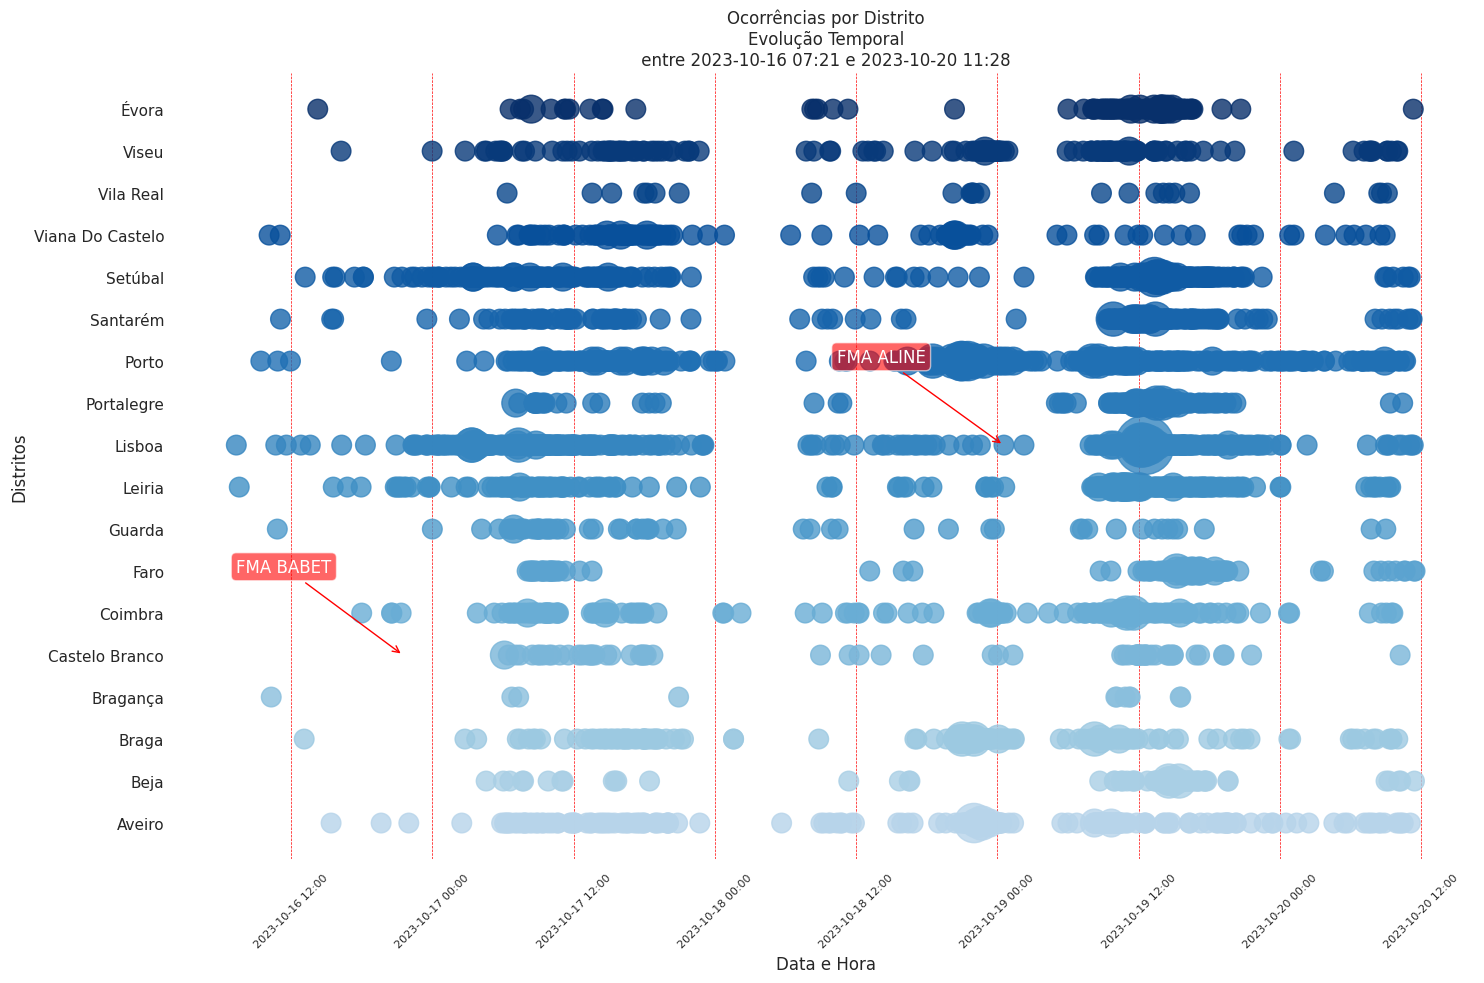

In [ ]:
# Group the data by 'district', 'date_time' and 'natureza' and count the number of occurrences
occurrences = data.groupby(['district', 'date_time', 'natureza']).size().reset_index(name='count')

# Assign a unique color to each district
unique_districts = occurrences['district'].unique()


# Assign a blue colormap to each district
colors = plt.cm.Blues(np.linspace(0.3, 1, len(unique_districts)))  # Start from 0.3 instead of 0 to avoid very light colors
district_color_map = dict(zip(unique_districts, colors))

# Update color values for the plot
color_values = occurrences['district'].map(lambda district: district_color_map[district])

# Update color values for the plot
color_values = occurrences['district'].map(lambda district: district_color_map[district])

# Prepare data for plotting
x = occurrences['date_time']
y = occurrences['district'].map(lambda district: unique_districts.tolist().index(district))  # Convert districts to numerical categories for plotting
sizes = occurrences['count'] * 200  # Multiply by a factor to make the size differences more visible
color_values = occurrences['district'].map(lambda district: district_color_map[district])

# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(15, 10))

# Create the scatter plot on the axes object
scatter = ax.scatter(x, y, c=color_values, s=sizes, alpha=0.8, marker='o')  # 'o' specifies a circular marker

# Add an annotation: this is optional and it can be changed

annotation_time = datetime(2023, 10, 19, 00, 30)  # replace with the specific date and time you want
y_coordinate = 9  # replace with the y-coordinate at which you want the annotation to appear
ax.annotate('FMA ALINE',
            xy=(annotation_time, y_coordinate),
            xytext=(-120,60),
            textcoords='offset points',
            arrowprops=dict(facecolor='red', edgecolor='red',arrowstyle='->'),
            fontsize=12,
            color='white',
            bbox=dict(boxstyle="round,pad=0.3", alpha=0.6, facecolor='red'))  # semi-transparent box


annotation_time_2 = datetime(2023, 10, 16, 21, 30)  # replace with the specific date and time you want
y_coordinate = 4  # replace with the y-coordinate at which you want the annotation to appear
ax.annotate('FMA BABET',
            xy=(annotation_time_2, y_coordinate),
            xytext=(-120,60),
            textcoords='offset points',
            arrowprops=dict(facecolor='red', edgecolor='red',arrowstyle='->'),
            fontsize=12,
            color='white',
            bbox=dict(boxstyle="round,pad=0.3", alpha=0.6, facecolor='red'))  # semi-transparent box

# Customize gridlines
ax.yaxis.grid(False)  # Remove horizontal lines
ax.xaxis.grid(color='red', linestyle='--', linewidth=0.5)  # Red, dashed vertical lines

# Remove borders
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_title(f'Ocorrências por Distrito\nEvolução Temporal\n entre {start_date_str} e {end_date_str} ')
ax.set_xlabel('Data e Hora')
ax.set_ylabel('Distritos')
ax.set_yticks(range(len(unique_districts)))  # Set y-ticks to district names
ax.set_yticklabels(unique_districts)
plt.xticks(rotation=45,fontsize=8)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  # format x-axis labels as date

plt.tight_layout()
filename =f'scatter_occurrences_per_district_{end_date_str}.png'
plt.savefig(filename, dpi=300,bbox_inches='tight')
files.download(filename)
plt.show()

#### Temporal Scatter Plot for type of Occurence (Gráfico de dispersão temporal por tipo de ocorrência)

**This code segment groups occurrence data by `natureza`(occurence type) and `date_time` tallying the number of occurrences for each combination. Unique colors are assigned to each 'natureza' type for plotting, and a scatter plot is generated to visualize the data. Optional annotations are included in the plot. The x-axis displays date and time labels, while the y-axis represents 'natureza' types. Gridlines and borders are customized for clarity. The resulting scatter plot is saved for further analysis and sharing within the notebook.**



---
**Este segmento de código agrupa dados de ocorrência por `natureza`(tipo de ocorrência) e `date_time` contabilizando o número de ocorrências para cada combinação. Cores exclusivas são atribuídas a cada tipo de 'natureza' para plotagem, e um gráfico de dispersão é gerado para visualizar os dados. Anotações opcionais estão incluídas no gráfico. O eixo x exibe rótulos de data e hora, enquanto o eixo y representa os tipos 'natureza'. As linhas de grade e as bordas são personalizadas para maior clareza. O gráfico de dispersão resultante é gravado para análise posterior.**


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

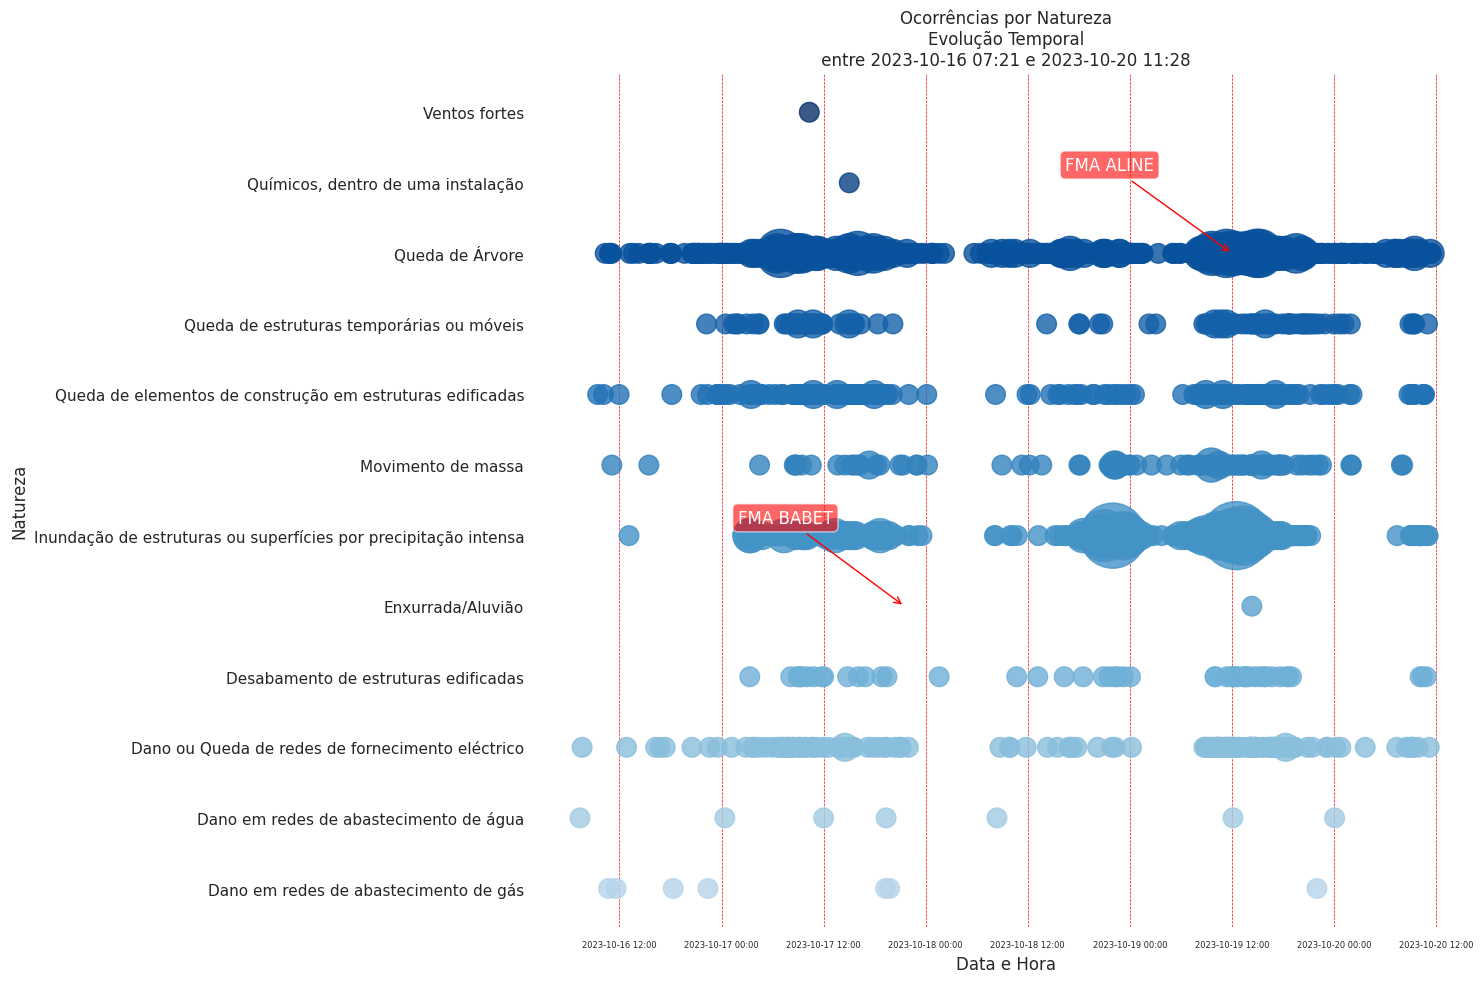

In [ ]:
# Group the data by 'natureza', 'date_time' and count the number of occurrences
occurrences = data.groupby(['natureza', 'date_time']).size().reset_index(name='count')

# Assign a unique color to each 'natureza' type
unique_naturezas = occurrences['natureza'].unique()

# Assign a blue colormap to each 'natureza' type
colors = plt.cm.Blues(np.linspace(0.3, 1, len(unique_naturezas)))  # Start from 0.3 instead of 0 to avoid very light colors
natureza_color_map = dict(zip(unique_naturezas, colors))

# Update color values for the plot
color_values = occurrences['natureza'].map(lambda natureza: natureza_color_map[natureza])

# Prepare data for plotting
x = occurrences['date_time']
y = occurrences['natureza'].map(lambda natureza: unique_naturezas.tolist().index(natureza))  # Convert naturezas to numerical categories for plotting
sizes = occurrences['count'] * 200  # Multiply by a factor to make the size differences more visible

# Create the figure and axes objects
fig, ax = plt.subplots(figsize=(15, 10))

# Create the scatter plot on the axes object
scatter = ax.scatter(x, y, c=color_values, s=sizes, alpha=0.8, marker='o')  # 'o' specifies a circular marker

# Add an annotation: this is optional

annotation_time = datetime(2023, 10, 17, 21, 30)  # replace with the specific date and time you want
y_coordinate = 4  # replace with the y-coordinate at which you want the annotation to appear
ax.annotate('FMA BABET',
            xy=(annotation_time, y_coordinate),
            xytext=(-120,60),
            textcoords='offset points',
            arrowprops=dict(facecolor='red', edgecolor='red',arrowstyle='->'),
            fontsize=12,
            color='white',
            bbox=dict(boxstyle="round,pad=0.3", alpha=0.6, facecolor='red'))  # semi-transparent box

annotation_time_2 = datetime(2023, 10, 19, 12, 00)  # replace with the specific date and time you want
y_coordinate = 9  # replace with the y-coordinate at which you want the annotation to appear
ax.annotate('FMA ALINE',
            xy=(annotation_time_2, y_coordinate),
            xytext=(-120,60),
            textcoords='offset points',
            arrowprops=dict(facecolor='red', edgecolor='red',arrowstyle='->'),
            fontsize=12,
            color='white',
            bbox=dict(boxstyle="round,pad=0.3", alpha=0.6, facecolor='red'))  # semi-transparent box

# Customize gridlines
ax.yaxis.grid(False)  # Remove horizontal lines
ax.xaxis.grid(color='red', linestyle='--', linewidth=0.5)  # Red, dashed vertical lines

# Remove borders
for spine in ax.spines.values():
    spine.set_visible(False)

# Title and labels
ax.set_title(f'Ocorrências por Natureza\nEvolução Temporal\n entre {start_date_str} e {end_date_str} ')
ax.set_xlabel('Data e Hora')
ax.set_ylabel('Natureza')
ax.set_yticks(range(len(unique_naturezas)))  # Set y-ticks to natureza names
ax.set_yticklabels(unique_naturezas)
plt.xticks(rotation=0, fontsize=6)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  # format x-axis labels as date

plt.tight_layout()
filename=f'scatter_occurrences_over_time_{end_date_str}.png'
plt.savefig(filename, dpi=300,bbox_inches='tight')
files.download(filename)
plt.show()